# Data Exploration

In [4]:
import torch
from datasets import load_dataset
import pandas as pd

data = load_dataset("json", data_files="./data/Slovene dataset/SPZ_contradictions_final.json")
df = pd.DataFrame(data["train"])

In [3]:
df

,title,content,contradictions
0,Vsebina zakona | 1. člen,[Ta zakon ureja temeljna načela stvarnega prav...,[Ta zakon ne ureja temeljnih načel stvarnega p...
1,Stvarne pravice | 2. člen,"[Stvarne pravice so:, - lastninska pravica...","[Stvarne pravice so lahko katerakoli pravica, ..."
2,Predmet stvarne pravice | 3. člen,"[(1) Predmet stvarne pravice je stvar., (2) Pr...",[Predmet stvarne pravice je lahko tudi storite...
3,Sposobnost stvari | 4. člen,"[Predmet stvarnih pravic ne more biti stvar, z...","[Predmet stvarnih pravic je lahko tudi stvar, ..."
4,Učinek stvarnih pravic | 5. člen,[Imetnica oziroma imetnik (v nadaljnjem besedi...,[Imetnik stvarne pravice lahko svojo pravico u...
...,...,...,...
264,Veljavnost pravnih poslov | 267. člen,"[(1) Pravni posli, ki so bili veljavno sklenje...","[Pravni posli, sklenjeni pred uveljavitvijo te..."
265,Nadaljevanje postopkov | 268. člen,"[Vsi postopki, ki so se začeli pred uveljavitv...","[Vsi postopki, ki so se začeli pred uveljavitv..."
266,Trajanje priposestvovanja | 269. člen,"[(1) Glede priposestvovalne dobe, ki je začela...","[Za priposestvovalno dobo, ki je začela teči p..."
267,Etažna lastnina | 270. člen,"[(1) Etažni lastniki, ki so pridobili etažno l...","[Etažni lastniki, ki so pridobili etažno lastn..."


# Needed Code

In [5]:
import pandas as pd
import numpy as np
import datasets
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack
from sklearn.model_selection import RandomizedSearchCV
from tabulate import tabulate

from transformers import Trainer
from sklearn.metrics import classification_report
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
train_data_path = "./data/English dataset/train.jsonl"
test_data_path = "./data/English dataset/test.jsonl"

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Domen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Domen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Domen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Domen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def pretty_print_report_dict(report):
	report_df = pd.DataFrame(report).transpose()
	report_df = report_df.round(3)

	class_metrics = report_df.iloc[:-3, :].copy()

	summary_metrics = report_df.iloc[-3:, :].copy()
	summary_metrics = summary_metrics.drop(columns=['support'])

	print("CLASS PERFORMANCE")
	print(tabulate(class_metrics, headers='keys', tablefmt='heavy_outline', numalign="center"))
	print()
	print("GLOBAL AVERAGES")
	print(tabulate(summary_metrics, headers='keys', tablefmt='heavy_outline', numalign="center"))

In [7]:
def contradictions(dataset, n = 1):
    h = set(dataset['hypothesis'])
    num_contras = dict(zip(h, [0]*len(h)))
    
    for i in range(len(dataset)):
        if dataset[i]['label'] == 1:
            num_contras[dataset[i]['hypothesis']] += 1
    
    num_contras = [v/n for k,v in num_contras.items()]
    return num_contras

def mistakes_per_hyp(dataset, predictions):
    h = set(dataset['hypothesis'])
    num_mist = dict(zip(h, [0]*len(h)))
    for i, hip in enumerate(dataset['hypothesis']):
        if dataset['label'][i] == predictions[i]:
            continue
        else:
            num_mist[hip] += 1
    num_mist = [v for k,v in num_mist.items()]
    return num_mist

def hypothesis_distribution(dataset):
    h = set(dataset['hypothesis'])
    dist = dict(zip(h, [0]*len(h)))
    for i, hip in enumerate(dataset['hypothesis']):
        dist[hip] += 1
    dist = [v for k,v in dist.items()]
    return dist


# Data Exploration

In [8]:
train_data = pd.DataFrame(datasets.load_dataset("json", data_files=train_data_path)["train"])
test_data = pd.DataFrame(datasets.load_dataset("json", data_files=test_data_path)["train"])
df = train_data.copy()
dft = test_data.copy()
label_map = {"Contradiction": 1, "Entailment": -1, "NotMentioned": 0}
train_data["label"] = train_data["label"]
test_data["label"] = test_data["label"]

In [11]:
train_data["label"].value_counts(normalize=True)

label
Entailment       0.490891
NotMentioned     0.392157
Contradiction    0.116952
Name: proportion, dtype: float64

In [12]:
test_data["label"].value_counts(normalize=True)

label
Entailment       0.462936
NotMentioned     0.431851
Contradiction    0.105213
Name: proportion, dtype: float64

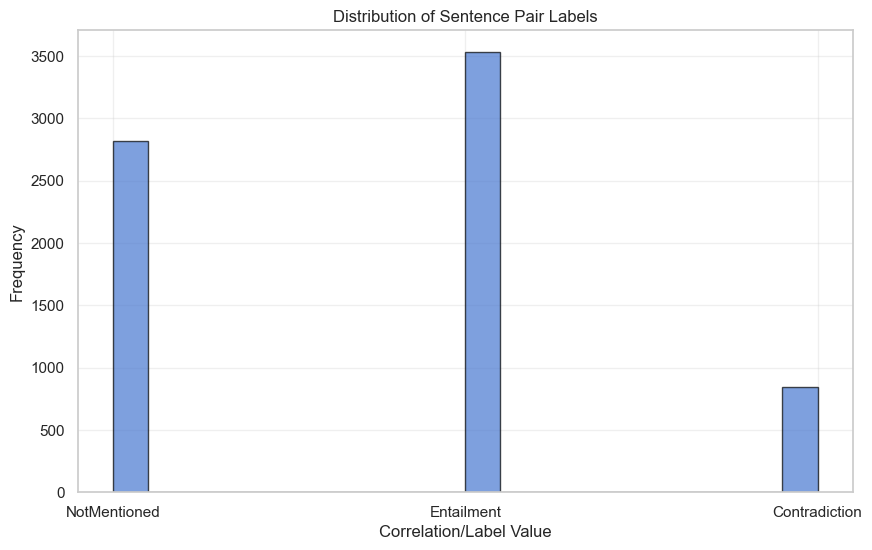

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['label'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Correlation/Label Value')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Pair Labels')
plt.grid(True, alpha=0.3)
plt.show()

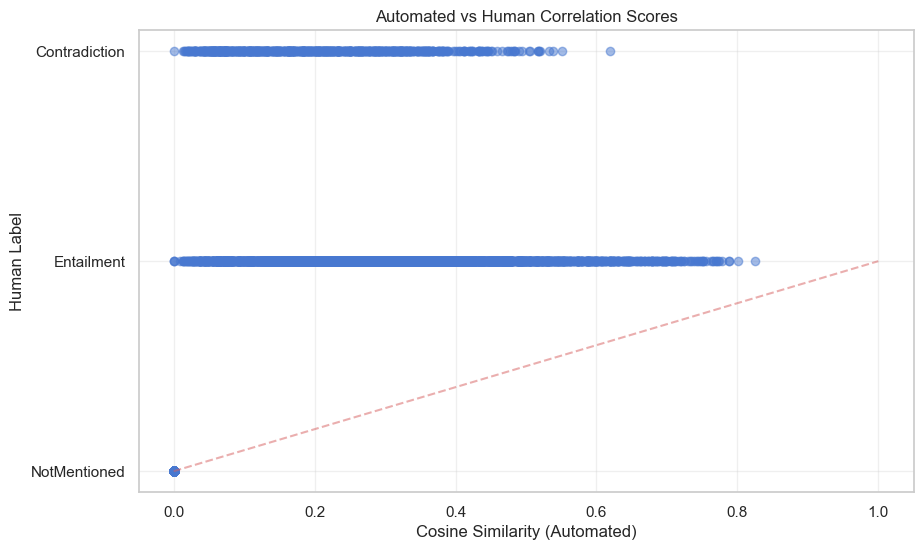

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Calculate similarity between sentences
vectorizer = TfidfVectorizer()
s1_vectors = vectorizer.fit_transform(df['hypothesis'])
s2_vectors = vectorizer.transform(df['premise'])

similarities = []
for i in range(len(df)):
    sim = cosine_similarity(s1_vectors[i], s2_vectors[i])[0][0]
    similarities.append(sim)

# Plot predicted vs actual similarity
plt.figure(figsize=(10, 6))
plt.scatter(similarities, df['label'], alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)  # Diagonal line for perfect correlation
plt.xlabel('Cosine Similarity (Automated)')
plt.ylabel('Human Label')
plt.title('Automated vs Human Correlation Scores')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import warnings

In [10]:
# Function to calculate word overlap and frequency differences
def analyze_word_freq_differences(row):
    # Tokenize and count words
    hyp_words = str(row['hypothesis']).lower().split()
    prem_words = str(row['premise']).lower().split()
    
    hyp_counter = Counter(hyp_words)
    prem_counter = Counter(prem_words)
    
    # Calculate metrics
    total_unique_words = len(set(hyp_words) | set(prem_words))
    overlapping_words = len(set(hyp_words) & set(prem_words))
    
    # Frequency ratio for common words
    common_words = set(hyp_words) & set(prem_words)
    freq_ratios = []
    for word in common_words:
        if prem_counter[word] > 0:
            ratio = hyp_counter[word] / prem_counter[word]
            freq_ratios.append(min(ratio, 10))  # Cap extreme values
    
    return pd.Series({
        'hyp_word_count': len(hyp_words),
        'prem_word_count': len(prem_words),
        'word_count_diff': len(hyp_words) - len(prem_words),
        'unique_words_total': total_unique_words,
        'overlap_ratio': overlapping_words / total_unique_words if total_unique_words > 0 else 0,
        'avg_freq_ratio': np.mean(freq_ratios) if freq_ratios else 0,
        'freq_ratio_std': np.std(freq_ratios) if freq_ratios else 0
    })

# Calculate features
print("Calculating word frequency features...")
freq_features = train_data.apply(analyze_word_freq_differences, axis=1)
train_data_enhanced = pd.concat([train_data, freq_features], axis=1)

Calculating word frequency features...


C:\Users\Domen\AppData\Local\Temp\ipykernel_11924\2735007746.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 2].boxplot(box_data, labels=sorted(train_data_enhanced['label'].unique()))


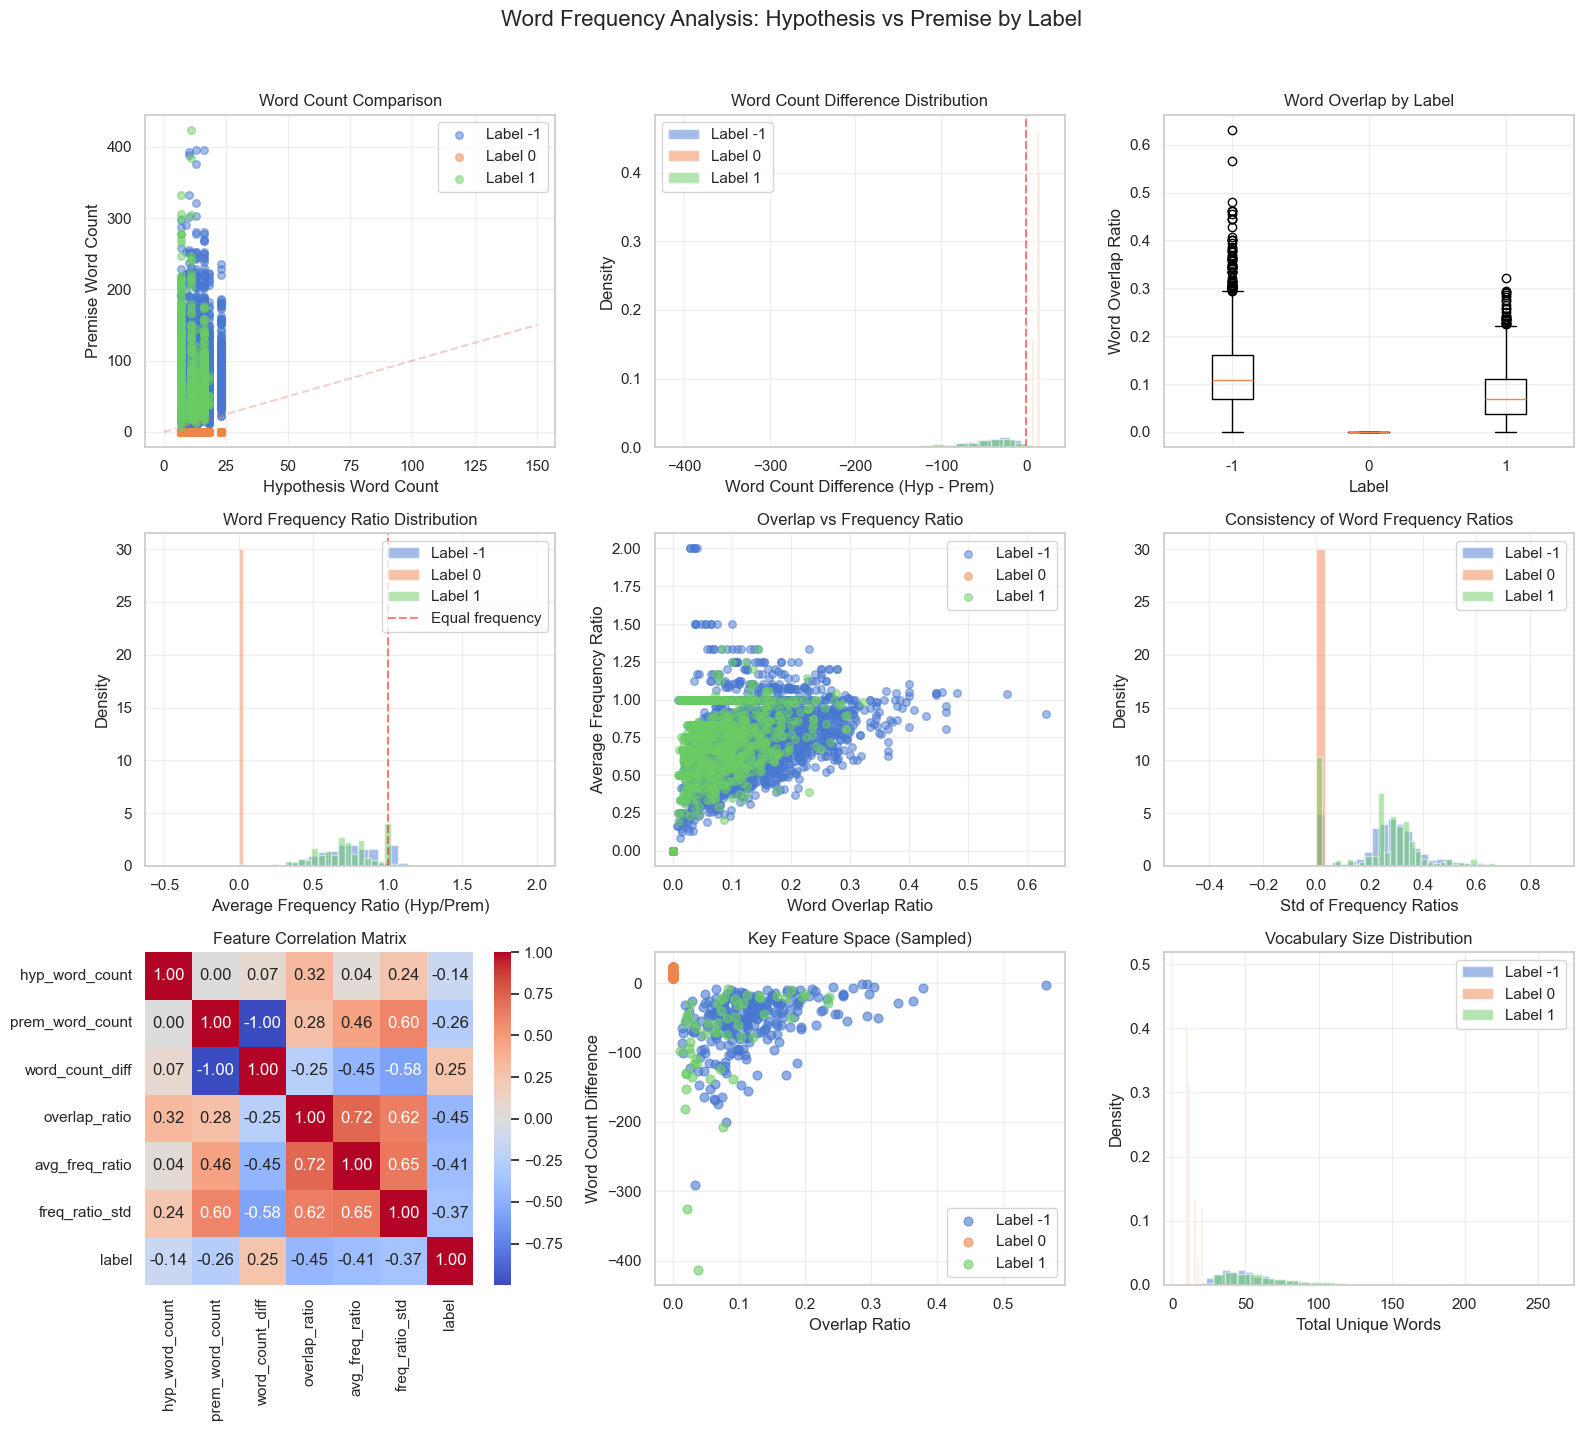

In [110]:
# Create a comprehensive visualization dashboard
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
fig.suptitle('Word Frequency Analysis: Hypothesis vs Premise by Label', fontsize=16, y=1.02)

# Plot 1: Word count comparison by label
for label in sorted(train_data_enhanced['label'].unique()):
    subset = train_data_enhanced[train_data_enhanced['label'] == label]
    axes[0, 0].scatter(subset['hyp_word_count'], subset['prem_word_count'], 
                      alpha=0.5, label=f'Label {label}', s=30)
axes[0, 0].plot([0, 150], [0, 150], 'r--', alpha=0.3)  # Diagonal line
axes[0, 0].set_xlabel('Hypothesis Word Count')
axes[0, 0].set_ylabel('Premise Word Count')
axes[0, 0].set_title('Word Count Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Word count difference distribution by label
for label in sorted(train_data_enhanced['label'].unique()):
    subset = train_data_enhanced[train_data_enhanced['label'] == label]
    axes[0, 1].hist(subset['word_count_diff'], bins=30, alpha=0.5, 
                   label=f'Label {label}', density=True)
axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Word Count Difference (Hyp - Prem)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Word Count Difference Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Overlap ratio by label (box plot)
box_data = [train_data_enhanced[train_data_enhanced['label'] == label]['overlap_ratio'] 
            for label in sorted(train_data_enhanced['label'].unique())]
axes[0, 2].boxplot(box_data, labels=sorted(train_data_enhanced['label'].unique()))
axes[0, 2].set_xlabel('Label')
axes[0, 2].set_ylabel('Word Overlap Ratio')
axes[0, 2].set_title('Word Overlap by Label')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Average frequency ratio distribution
for label in sorted(train_data_enhanced['label'].unique()):
    subset = train_data_enhanced[train_data_enhanced['label'] == label]
    axes[1, 0].hist(subset['avg_freq_ratio'], bins=30, alpha=0.5, 
                   label=f'Label {label}', density=True)
axes[1, 0].axvline(x=1, color='red', linestyle='--', alpha=0.5, label='Equal frequency')
axes[1, 0].set_xlabel('Average Frequency Ratio (Hyp/Prem)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Word Frequency Ratio Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Scatter of overlap vs frequency ratio
for label in sorted(train_data_enhanced['label'].unique()):
    subset = train_data_enhanced[train_data_enhanced['label'] == label]
    axes[1, 1].scatter(subset['overlap_ratio'], subset['avg_freq_ratio'], 
                      alpha=0.5, label=f'Label {label}', s=30)
axes[1, 1].set_xlabel('Word Overlap Ratio')
axes[1, 1].set_ylabel('Average Frequency Ratio')
axes[1, 1].set_title('Overlap vs Frequency Ratio')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Frequency ratio std distribution
for label in sorted(train_data_enhanced['label'].unique()):
    subset = train_data_enhanced[train_data_enhanced['label'] == label]
    axes[1, 2].hist(subset['freq_ratio_std'], bins=30, alpha=0.5, 
                   label=f'Label {label}', density=True)
axes[1, 2].set_xlabel('Std of Frequency Ratios')
axes[1, 2].set_ylabel('Density')
axes[1, 2].set_title('Consistency of Word Frequency Ratios')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# Plot 7: Heatmap of correlation between features and labels
correlation_data = train_data_enhanced[['hyp_word_count', 'prem_word_count', 
                                       'word_count_diff', 'overlap_ratio', 
                                       'avg_freq_ratio', 'freq_ratio_std', 'label']]
corr_matrix = correlation_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[2, 0])
axes[2, 0].set_title('Feature Correlation Matrix')

# Plot 8: Pair plot for top 3 features (sampled for clarity)
sample_size = min(500, len(train_data_enhanced))
sample_df = train_data_enhanced.sample(sample_size, random_state=42)
for label in sorted(sample_df['label'].unique()):
    subset = sample_df[sample_df['label'] == label]
    axes[2, 1].scatter(subset['overlap_ratio'], subset['word_count_diff'], 
                      alpha=0.6, label=f'Label {label}', s=40)
axes[2, 1].set_xlabel('Overlap Ratio')
axes[2, 1].set_ylabel('Word Count Difference')
axes[2, 1].set_title('Key Feature Space (Sampled)')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

# Plot 9: Distribution of total unique words
for label in sorted(train_data_enhanced['label'].unique()):
    subset = train_data_enhanced[train_data_enhanced['label'] == label]
    axes[2, 2].hist(subset['unique_words_total'], bins=30, alpha=0.5, 
                   label=f'Label {label}', density=True)
axes[2, 2].set_xlabel('Total Unique Words')
axes[2, 2].set_ylabel('Density')
axes[2, 2].set_title('Vocabulary Size Distribution')
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Statistical tests to see if differences are significant
from scipy import stats

print("\n" + "="*60)
print("STATISTICAL ANALYSIS OF WORD FREQUENCY FEATURES BY LABEL")
print("="*60)

features_to_test = ['word_count_diff', 'overlap_ratio', 'avg_freq_ratio', 'freq_ratio_std']
labels = sorted(train_data_enhanced['label'].unique())

for feature in features_to_test:
    print(f"\n--- {feature.upper().replace('_', ' ')} ---")
    
    # ANOVA test for multiple labels
    if len(labels) > 2:
        groups = [train_data_enhanced[train_data_enhanced['label'] == label][feature] 
                 for label in labels]
        f_stat, p_value = stats.f_oneway(*groups)
        print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.6f}")
        
        if p_value < 0.05:
            print("Significant difference found between labels!")
    
    # Pairwise comparisons
    print("\nPairwise comparisons (t-test):")
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            group1 = train_data_enhanced[train_data_enhanced['label'] == labels[i]][feature]
            group2 = train_data_enhanced[train_data_enhanced['label'] == labels[j]][feature]
            t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
            print(f"Label {labels[i]} vs {labels[j]}: t={t_stat:.3f}, p={p_val:.5f}")
    
    # Summary statistics
    print("\nSummary statistics by label:")
    for label in labels:
        subset = train_data_enhanced[train_data_enhanced['label'] == label][feature]
        print(f"  Label {label}: mean={subset.mean():.3f}, std={subset.std():.3f}")


STATISTICAL ANALYSIS OF WORD FREQUENCY FEATURES BY LABEL

--- WORD COUNT DIFF ---
ANOVA F-statistic: 3056.1837, p-value: 0.000000
Significant difference found between labels!

Pairwise comparisons (t-test):
Label Contradiction vs Entailment: t=-4.029, p=0.00006
Label Contradiction vs NotMentioned: t=-41.639, p=0.00000
Label Entailment vs NotMentioned: t=-87.838, p=0.00000

Summary statistics by label:
  Label Contradiction: mean=-66.174, std=54.821
  Label Entailment: mean=-57.903, std=47.522
  Label NotMentioned: mean=12.587, std=3.458

--- OVERLAP RATIO ---
ANOVA F-statistic: 3933.8189, p-value: 0.000000
Significant difference found between labels!

Pairwise comparisons (t-test):
Label Contradiction vs Entailment: t=-16.587, p=0.00000
Label Contradiction vs NotMentioned: t=41.302, p=0.00000
Label Entailment vs NotMentioned: t=99.785, p=0.00000

Summary statistics by label:
  Label Contradiction: mean=0.082, std=0.058
  Label Entailment: mean=0.121, std=0.072
  Label NotMentioned: me

In [112]:
# Identify words that appear more frequently in specific label categories
print("\n" + "="*60)
print("TOP DISCRIMINATIVE WORDS ANALYSIS")
print("="*60)

# Analyze for each label
for label in sorted(train_data_enhanced['label'].unique()):
    print(f"\n=== Words characteristic of Label {label} ===")
    
    # Get sentences for this label vs others
    label_sentences = train_data_enhanced[train_data_enhanced['label'] == label]
    other_sentences = train_data_enhanced[train_data_enhanced['label'] != label]
    
    # Combine hypothesis and premise
    label_text = ' '.join(label_sentences['hypothesis'].tolist() + 
                         label_sentences['premise'].tolist())
    other_text = ' '.join(other_sentences['hypothesis'].tolist() + 
                         other_sentences['premise'].tolist())
    
    # Count words
    label_words = Counter(label_text.lower().split())
    other_words = Counter(other_text.lower().split())
    
    # Calculate normalized frequencies
    label_total = sum(label_words.values())
    other_total = sum(other_words.values())
    
    # Find words that are overrepresented in this label
    distinctive_words = []
    for word in set(list(label_words.keys()) + list(other_words.keys())):
        if word.isalpha() and len(word) > 2:  # Filter out short words and non-words
            label_freq = label_words.get(word, 0) / label_total
            other_freq = other_words.get(word, 0) / other_total
            if label_freq > 0 and other_freq > 0:
                ratio = label_freq / other_freq
                if ratio > 1.5:  # At least 50% more frequent
                    distinctive_words.append((word, ratio, label_freq, other_freq))
    
    # Sort and display top words
    distinctive_words.sort(key=lambda x: x[1], reverse=True)
    print(f"Top 10 distinctive words for label {label}:")
    for word, ratio, l_freq, o_freq in distinctive_words[:10]:
        print(f"  '{word}': {ratio:.2f}x more frequent "
              f"(in-label: {l_freq:.4f}, others: {o_freq:.4f})")


TOP DISCRIMINATIVE WORDS ANALYSIS

=== Words characteristic of Label -1 ===
Top 10 distinctive words for label -1:
  'continue': 63.03x more frequent (in-label: 0.0006, others: 0.0000)
  'nothing': 58.21x more frequent (in-label: 0.0005, others: 0.0000)
  'becomes': 57.47x more frequent (in-label: 0.0005, others: 0.0000)
  'seek': 54.88x more frequent (in-label: 0.0005, others: 0.0000)
  'reference': 34.48x more frequent (in-label: 0.0003, others: 0.0000)
  'securities': 30.40x more frequent (in-label: 0.0003, others: 0.0000)
  'protective': 28.74x more frequent (in-label: 0.0005, others: 0.0000)
  'lawfully': 26.33x more frequent (in-label: 0.0002, others: 0.0000)
  'law': 25.96x more frequent (in-label: 0.0005, others: 0.0000)
  'construed': 25.03x more frequent (in-label: 0.0005, others: 0.0000)

=== Words characteristic of Label 0 ===
Top 10 distinctive words for label 0:
  'embody': 53.05x more frequent (in-label: 0.0102, others: 0.0002)
  'engineer': 44.41x more frequent (in-lab

In [113]:
print("\n" + "="*60)
print("KEY INSIGHTS SUMMARY")
print("="*60)

# Calculate which features are most predictive
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare data for feature importance
X = train_data_enhanced[['hyp_word_count', 'prem_word_count', 
                         'word_count_diff', 'overlap_ratio', 
                         'avg_freq_ratio', 'freq_ratio_std']]
y = train_data_enhanced['label']

# Train a simple model to get feature importance
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

print("\nFeature Importance for Predicting Labels:")
for feature, importance in zip(X.columns, clf.feature_importances_):
    print(f"  {feature}: {importance:.3f}")

print("\nInterpretation Guidelines:")
print("1. Overlap Ratio > 0.5: High word overlap between hypothesis and premise")
print("2. Avg Frequency Ratio > 1: Words appear more in hypothesis than premise")
print("3. Word Count Diff > 0: Hypothesis is longer than premise")
print("4. High freq_ratio_std: Inconsistent word frequencies across sentences")


KEY INSIGHTS SUMMARY

Feature Importance for Predicting Labels:
  hyp_word_count: 0.072
  prem_word_count: 0.276
  word_count_diff: 0.218
  overlap_ratio: 0.181
  avg_freq_ratio: 0.178
  freq_ratio_std: 0.075

Interpretation Guidelines:
1. Overlap Ratio > 0.5: High word overlap between hypothesis and premise
2. Avg Frequency Ratio > 1: Words appear more in hypothesis than premise
3. Word Count Diff > 0: Hypothesis is longer than premise
4. High freq_ratio_std: Inconsistent word frequencies across sentences


# Data preprocessing

In [12]:
def preprocess_text(text): # From the labs
	# Tokenize the text into words
	words = word_tokenize(text.lower())  # Convert text to lowercase

	# Remove punctuation
	table = str.maketrans('', '', string.punctuation)
	words = [word.translate(table) for word in words if word.isalpha()]

	# Remove stopwords
	stop_words = set(stopwords.words('english'))
	words = [word for word in words if word not in stop_words]

	# Lemmatization
	lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

	# Join the words back into a string
	preprocessed_text = ' '.join(lemmatized_words)
	return preprocessed_text

(We load the dataset. We join togeder eintailment and not mentioned, so we can focus on predicting only if something is a contradiction)

In [13]:
print(preprocess_text("It's currently raining"),"=", preprocess_text("It's not currently raining"))

currently raining = currently raining


In [14]:
train_data = pd.DataFrame(datasets.load_dataset("json", data_files=train_data_path)["train"])
test_data = pd.DataFrame(datasets.load_dataset("json", data_files=test_data_path)["train"])

label_map = {"Contradiction": 1, "Entailment": 0, "NotMentioned": 0}
train_data["label"] = train_data["label"]
test_data["label"] = test_data["label"]

train_data = train_data.drop("doc_id", axis=1)
train_data = train_data.drop("key", axis=1)
test_data = test_data.drop("doc_id", axis=1)
test_data = test_data.drop("key", axis=1)

In [15]:
(train_hypothesis,test_hypothesis) = (set(train_data['hypothesis']), set(test_data['hypothesis']))
print(len(train_hypothesis), len(test_hypothesis), len(train_hypothesis.difference(test_hypothesis))) # all hypothesis are the same

17 17 0


In [48]:
(train_premise,test_premise) = (set(train_data['premise']), set(test_data['premise']))
print(len(train_premise), len(test_premise), len(train_premise)-len(train_premise.difference(test_premise))) # they only share 49 premises

3716 1013 49


In [49]:
h_lens = train_data['hypothesis'].map(len)
print(sum(h_lens)/len(h_lens))

97.17647058823529


In [50]:
h_lens = train_data['premise'].map(len)
print(sum(h_lens)/len(h_lens))

296.27826449728826


C:\Users\Domen\AppData\Local\Temp\ipykernel_23516\1880768571.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


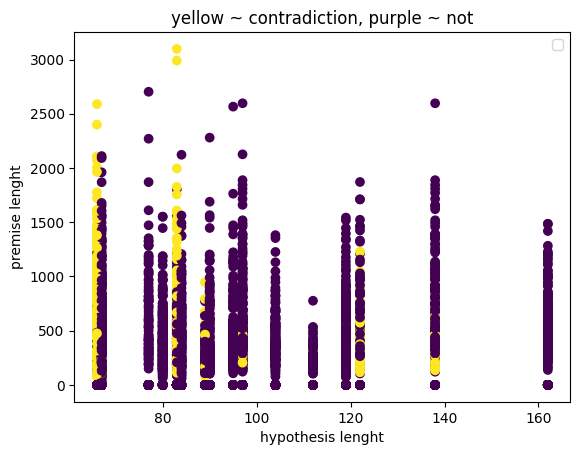

In [16]:
import matplotlib.pyplot as plt

def vis_len_dependance(data):
    h = data['hypothesis'].map(len)
    p = data['premise'].map(len)
    c = data['label'].map(label_map)
    plt.scatter(h,p,c=c, )
    plt.legend()
    plt.xlabel("hypothesis lenght")
    plt.ylabel("premise lenght")
    plt.title("yellow ~ contradiction, purple ~ not")
vis_len_dependance(df)
plt.show()

(After we load the dataset, we inspect it for class inbalance)

(We can see that most of the data isn't contradictions. The data is quite imbalanced)

In [17]:
train_data["label"] = df["label"].map(label_map)
test_data["label"] = dft["label"].map(label_map)

In [18]:
from datasets import Dataset
import numpy as np

print("train_data")
num_contras_train_array = np.array(contradictions(Dataset.from_pandas(train_data)))
labels_train = np.minimum(num_contras_train_array, 1)
print(num_contras_train_array)
print("How many hypothesis have a contradiction in the corpus: ", labels_train.sum()/len(labels_train))

print("test data")
num_contras_test_array = np.array(contradictions(Dataset.from_pandas(test_data)))
labels_test = np.minimum(num_contras_test_array, 1)
print(num_contras_test_array)
print("How many hypothesis have a contradiction in the corpus: ", labels_test.sum()/len(labels_test))

train_data
[  1.   1.   2.   0.  76. 309.   0.  13. 112. 194. 111.   0.  11.   4.
   0.   0.   7.]
How many hypothesis have a contradiction in the corpus:  0.7058823529411765
test data
[ 0.  1.  0.  0. 25. 88.  0.  1. 36. 30. 25.  0.  4.  3.  0.  0.  7.]
How many hypothesis have a contradiction in the corpus:  0.5882352941176471


In [16]:
longest_premise = max(train_data['premise'].apply(len).max(), test_data['premise'].apply(len).max())
longest_hypotises = max(train_data['hypothesis'].apply(len).max(), test_data['hypothesis'].apply(len).max())
longest_sentance = max(longest_premise, longest_hypotises)
print("Longest premise: ", longest_premise)
print("Longest hypothesis: ", longest_hypotises)

print("---------------------------------")
mean = np.mean(train_data['premise'].apply(len))
std = np.std(train_data['premise'].apply(len))

print("Mean premise length: ", mean)
print("+1 std: ", mean+std)
print("+2 std: ", mean+2*std)
print("+3 std: ", mean+3*std)

Longest premise:  3098
Longest hypothesis:  162
---------------------------------
Mean premise length:  296.27826449728826
+1 std:  651.2505192635402
+2 std:  1006.2227740297922
+3 std:  1361.1950287960442


(We inspect the lenght of the data. We do this to see if it would be beneficial only keeping smaller sizes of the data, so we can cleanly feed it into BERT model. We conclude that we would need to thin our data too much to be worth it)

# Traditional ML

In [19]:
train_data_preprocessed = train_data.copy()
test_data_preprocessed = test_data.copy()

train_data_preprocessed["premise"] = train_data_preprocessed["premise"].map(preprocess_text)
train_data_preprocessed["hypothesis"] = train_data_preprocessed["hypothesis"].map(preprocess_text)

test_data_preprocessed["premise"] = test_data_preprocessed["premise"].map(preprocess_text)
test_data_preprocessed["hypothesis"] = test_data_preprocessed["hypothesis"].map(preprocess_text)

def vectorize(train_data_preprocessed, test_data_preprocessed):
    vectorizer_premise = TfidfVectorizer()
    vectorizer_hypothesis = TfidfVectorizer()

    train_data_vectorised = train_data.copy()

    X_premise= vectorizer_premise.fit_transform(train_data_preprocessed["premise"])
    X_hypothesis = vectorizer_hypothesis.fit_transform(train_data_preprocessed["hypothesis"])
    train_data_vectorised = hstack([X_premise, X_hypothesis])

    Y_premise = vectorizer_premise.transform(test_data_preprocessed["premise"])
    Y_hypothesis = vectorizer_hypothesis.transform(test_data_preprocessed["hypothesis"])
    test_data_vectorised = hstack([Y_premise, Y_hypothesis])
    return (train_data_vectorised, test_data_vectorised)

In [20]:
(train_data_vectorised, test_data_vectorised) = vectorize(train_data_preprocessed, test_data_preprocessed)
(train_not_vect, test_not_vect) = vectorize(train_data, test_data)

## Logistic regression

In [252]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

grid_serch_dict = {
	"l1_ratio": [0, 0.5, 1],
	"C": [0.1, 0.5, 1.0, 2.0, 10, 50],
	"class_weight": [None, "balanced"],
	"solver": ["saga"]
}

logreg_model = RandomizedSearchCV(LogisticRegression(max_iter=5000), grid_serch_dict, n_iter=10, cv=3, scoring='f1')
logreg_model.fit(train_data_vectorised, train_data["label"])

predictions = logreg_model.predict(test_data_vectorised)

display_params = [[k, str(v)] for k, v in logreg_model.best_params_.items()]
print(tabulate(display_params, headers=["Hyperparameter", "Value"], tablefmt="heavy_outline"))

e:\ProjectsSSD\School\IS\Idk\SkupnoAng\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
e:\ProjectsSSD\School\IS\Idk\SkupnoAng\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Hyperparameter   ┃ Value    ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━┫
┃ solver           ┃ saga     ┃
┃ l1_ratio         ┃ 0.5      ┃
┃ class_weight     ┃ balanced ┃
┃ C                ┃ 2.0      ┃
┗━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━┛


e:\ProjectsSSD\School\IS\Idk\SkupnoAng\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [253]:
report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
pretty_print_report_dict(report_dict)

CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.988    ┃  0.959   ┃   0.973    ┃   1871    ┃
┃ 1  ┃    0.721    ┃  0.905   ┃   0.802    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.953    ┃  0.953   ┃   0.953    ┃
┃ macro avg    ┃    0.855    ┃  0.932   ┃   0.888    ┃
┃ weighted avg ┃    0.96     ┃  0.953   ┃   0.955    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

grid_serch_dict = {
	"n_estimators": [50, 100, 200],
	"max_depth": [None, 5, 10, 20],
	"min_samples_split": [2, 5, 10, 20, 50],
	"class_weight": [None, "balanced"]
}

rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=67), grid_serch_dict, n_iter=15, cv=3, scoring='f1')
rf_model.fit(train_data_vectorised, train_data["label"])

predictions = rf_model.predict(test_data_vectorised)

display_params = [[k, str(v)] for k, v in rf_model.best_params_.items()]
print(tabulate(display_params, headers=["Hyperparameter", "Value"], tablefmt="heavy_outline"))

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Hyperparameter    ┃ Value    ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━┫
┃ n_estimators      ┃ 50       ┃
┃ min_samples_split ┃ 10       ┃
┃ max_depth         ┃ None     ┃
┃ class_weight      ┃ balanced ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━┛


In [20]:
report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
pretty_print_report_dict(report_dict)

CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.981    ┃   0.98   ┃    0.98    ┃   1871    ┃
┃ 1  ┃    0.833    ┃  0.836   ┃   0.834    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.965    ┃  0.965   ┃   0.965    ┃
┃ macro avg    ┃    0.907    ┃  0.908   ┃   0.907    ┃
┃ weighted avg ┃    0.965    ┃  0.965   ┃   0.965    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


In [42]:
test_dataset = Dataset.from_pandas(test_data)
train_dataset = Dataset.from_pandas(train_data)

In [67]:
cont_test = contradictions(test_dataset, n = 1)
cont_train = contradictions(train_dataset, n = 1)
mistakes = mistakes_per_hyp(test_dataset, predictions)
ls = list(zip(cont_train, cont_test, mistakes))

for i in ls:
    print(i)


(111.0, 25.0, 11)
(7.0, 7.0, 7)
(112.0, 36.0, 23)
(13.0, 1.0, 1)
(0.0, 0.0, 0)
(309.0, 88.0, 7)
(0.0, 0.0, 0)
(4.0, 3.0, 3)
(1.0, 0.0, 0)
(0.0, 0.0, 0)
(0.0, 0.0, 0)
(1.0, 1.0, 1)
(0.0, 0.0, 0)
(11.0, 4.0, 4)
(194.0, 30.0, 7)
(76.0, 25.0, 9)
(2.0, 0.0, 0)


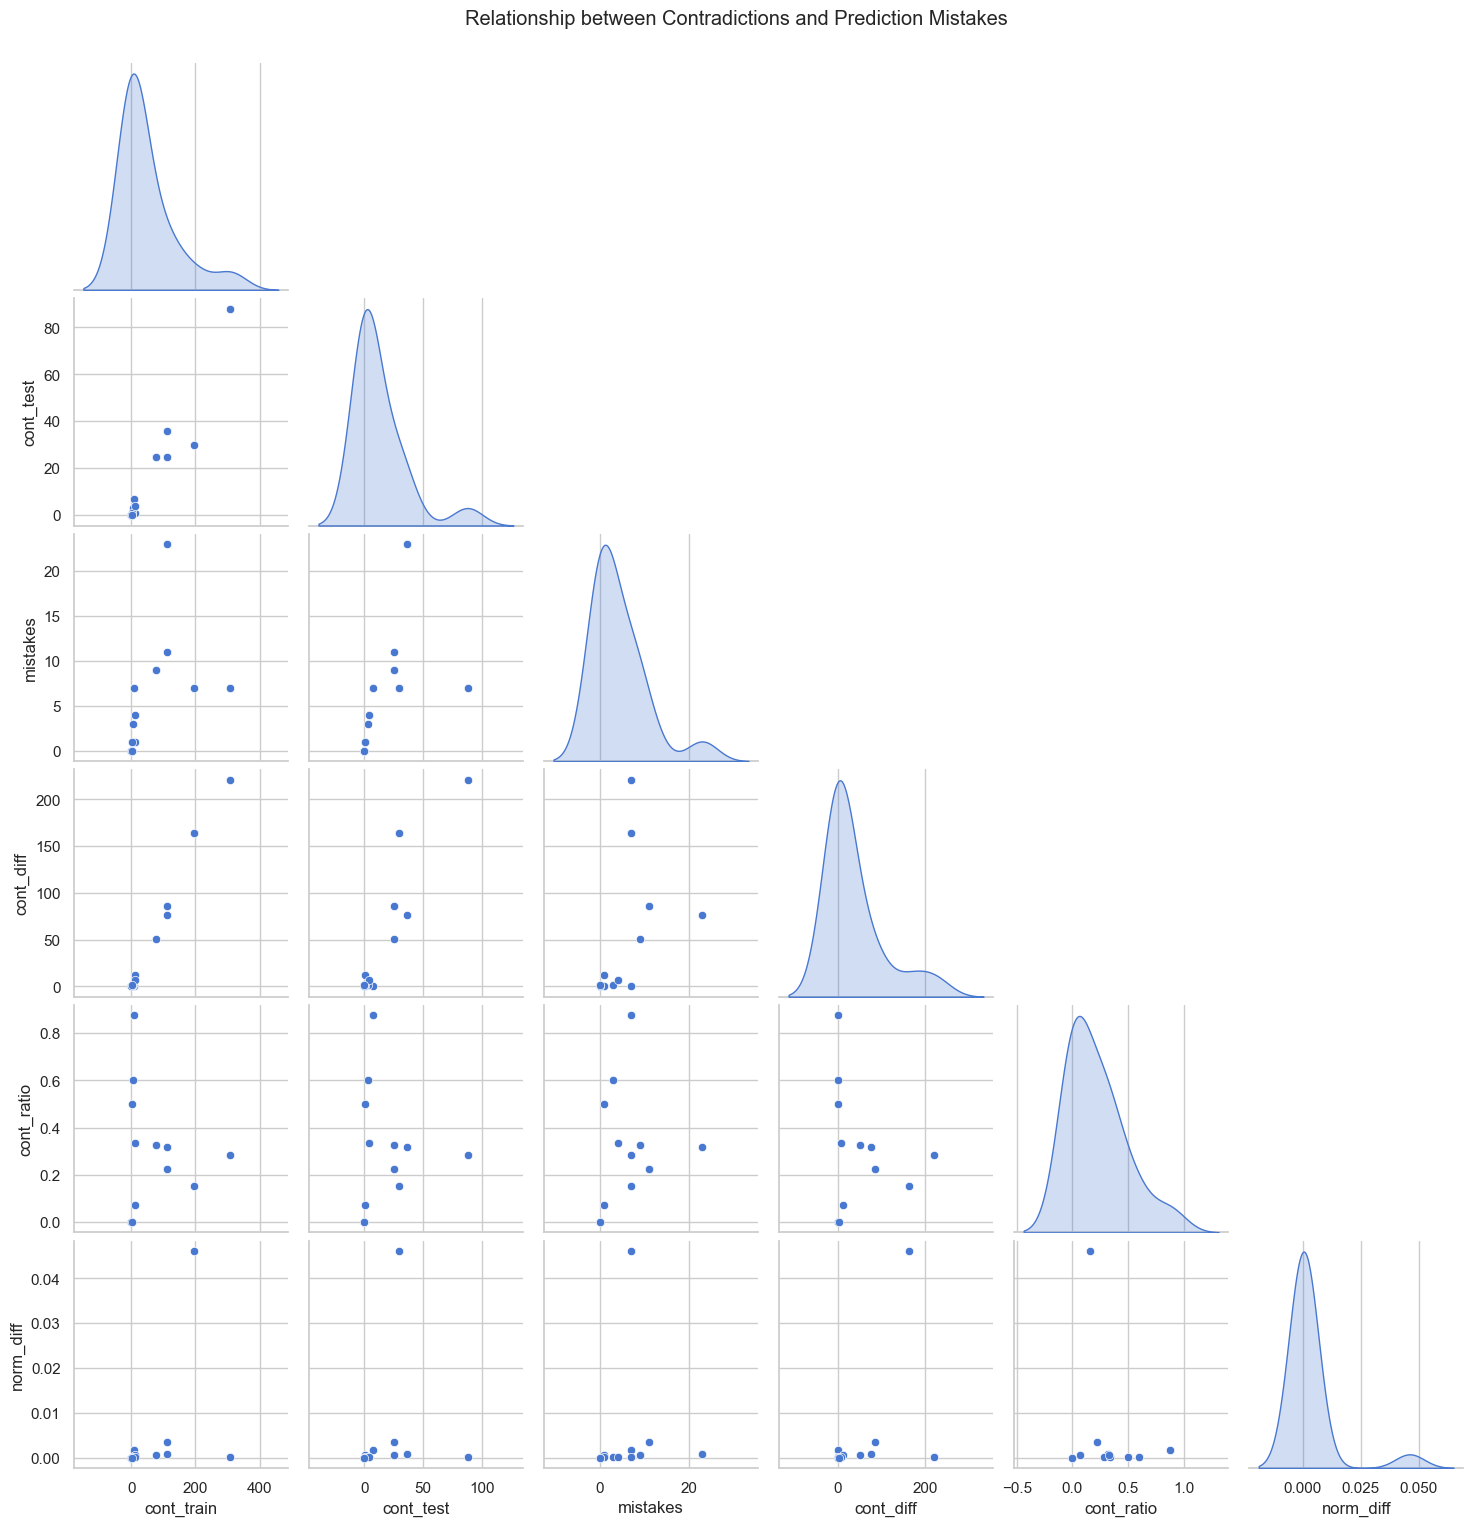

In [82]:
import seaborn as sns

# Convert to DataFrame
df = pd.DataFrame(ls, columns=['cont_train', 'cont_test', 'mistakes'])

# Add derived metrics
df['cont_diff'] = df['cont_train'] - df['cont_test']  # Difference between train and test
df['cont_ratio'] = df['cont_test'] / (df['cont_train'] + 1)  # Ratio (add 1 to avoid division by zero)
df['norm_diff'] = (df['cont_train']/423 - df['cont_test']/123)**2

# Create scatter plot matrix
sns.set(style='whitegrid', palette='muted')
fig = sns.pairplot(df, diag_kind='kde', corner=True)
plt.suptitle('Relationship between Contradictions and Prediction Mistakes', y=1.02)
plt.show()

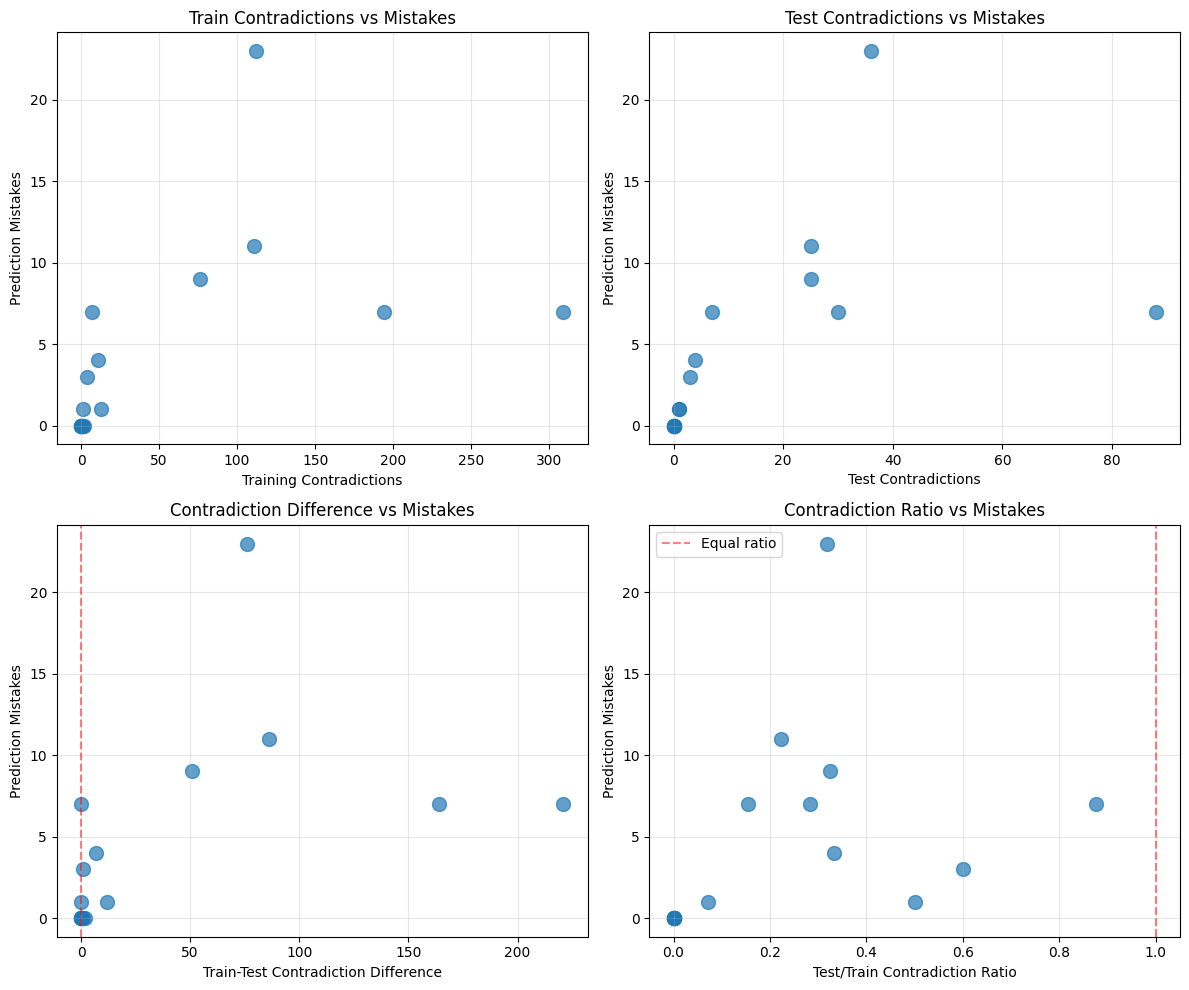

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

# Convert to DataFrame
df = pd.DataFrame(ls, columns=['cont_train', 'cont_test', 'mistakes'])

# Add derived metrics
df['cont_diff'] = df['cont_train'] - df['cont_test']  # Difference between train and test
df['cont_ratio'] = df['cont_test'] / (df['cont_train'] + 1)  # Ratio (add 1 to avoid division by zero)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Train contradictions vs mistakes
axes[0, 0].scatter(df['cont_train'], df['mistakes'], alpha=0.7, s=100)
axes[0, 0].set_xlabel('Training Contradictions')
axes[0, 0].set_ylabel('Prediction Mistakes')
axes[0, 0].set_title('Train Contradictions vs Mistakes')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Test contradictions vs mistakes
axes[0, 1].scatter(df['cont_test'], df['mistakes'], alpha=0.7, s=100)
axes[0, 1].set_xlabel('Test Contradictions')
axes[0, 1].set_ylabel('Prediction Mistakes')
axes[0, 1].set_title('Test Contradictions vs Mistakes')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Difference vs mistakes
axes[1, 0].scatter(df['cont_diff'], df['mistakes'], alpha=0.7, s=100)
axes[1, 0].set_xlabel('Train-Test Contradiction Difference')
axes[1, 0].set_ylabel('Prediction Mistakes')
axes[1, 0].set_title('Contradiction Difference vs Mistakes')
axes[1, 0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Ratio vs mistakes
axes[1, 1].scatter(df['cont_ratio'], df['mistakes'], alpha=0.7, s=100)
axes[1, 1].set_xlabel('Test/Train Contradiction Ratio')
axes[1, 1].set_ylabel('Prediction Mistakes')
axes[1, 1].axvline(x=1, color='r', linestyle='--', alpha=0.5, label='Equal ratio')
axes[1, 1].set_title('Contradiction Ratio vs Mistakes')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

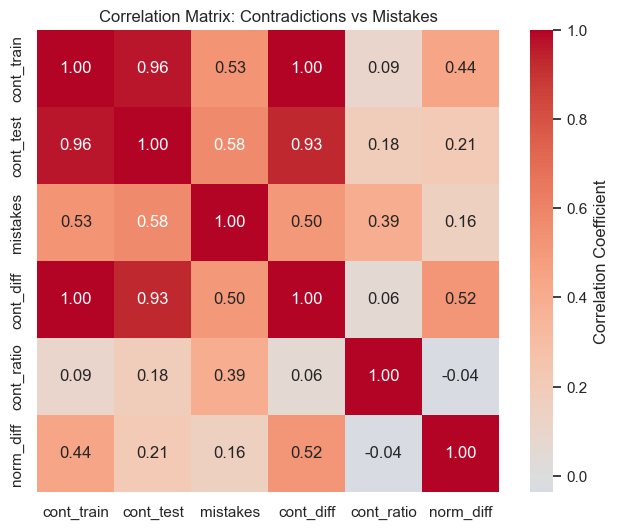

In [83]:
import seaborn as sns
# Calculate correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix: Contradictions vs Mistakes')
plt.show()

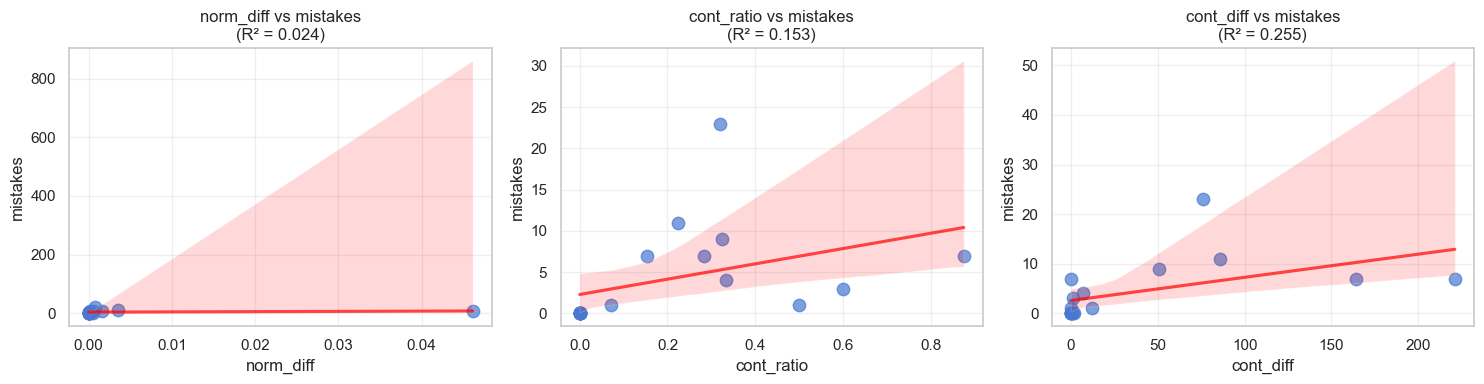

In [84]:
# Calculate R² for different relationships
from sklearn.metrics import r2_score

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

relationships = [
    ('norm_diff', 'mistakes'),
    ('cont_ratio', 'mistakes'),
    ('cont_diff', 'mistakes')
]

for idx, (x_col, y_col) in enumerate(relationships):
    # Calculate R²
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    r2 = r2_score(y, np.poly1d(np.polyfit(x.flatten(), y, 1))(x.flatten()))
    
    # Create regression plot
    sns.regplot(data=df, x=x_col, y=y_col, ax=axes[idx], 
                scatter_kws={'s': 80, 'alpha': 0.7},
                line_kws={'color': 'red', 'alpha': 0.7})
    
    axes[idx].set_title(f'{x_col} vs {y_col}\n(R² = {r2:.3f})')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## SVC

In [256]:
from sklearn.svm import SVC

grid_serch_dict = {
	"C": [0.1, 0.5, 1.0, 2.0, 10, 50],
	"kernel": ["linear", "sigmoid", "rbf"],
	"class_weight": [None, "balanced"]
}

svm_model = RandomizedSearchCV(SVC(), grid_serch_dict, n_iter=10, cv=3, scoring='f1')
svm_model.fit(train_data_vectorised, train_data["label"])

predictions = svm_model.predict(test_data_vectorised)

display_params = [[k, str(v)] for k, v in svm_model.best_params_.items()]
print(tabulate(display_params, headers=["Hyperparameter", "Value"], tablefmt="heavy_outline"))

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Hyperparameter   ┃ Value    ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━┫
┃ kernel           ┃ rbf      ┃
┃ class_weight     ┃ balanced ┃
┃ C                ┃ 10       ┃
┗━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━┛


In [257]:
report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
pretty_print_report_dict(report_dict)

CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.983    ┃  0.988   ┃   0.985    ┃   1871    ┃
┃ 1  ┃    0.891    ┃  0.855   ┃   0.872    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.974    ┃  0.974   ┃   0.974    ┃
┃ macro avg    ┃    0.937    ┃  0.921   ┃   0.929    ┃
┃ weighted avg ┃    0.973    ┃  0.974   ┃   0.973    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


# Transformer-Based Classifier

## Training

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

def preprocess_function(examples):
	inputs = tokenizer(examples["premise"], examples["hypothesis"], 
			max_length=1024, truncation="only_first", padding="max_length")

	global_attention_mask = [[0] * len(ids) for ids in inputs["input_ids"]]

	for mask in global_attention_mask:
		mask[0] = 1 
		
	inputs["global_attention_mask"] = global_attention_mask
	return inputs

model_name = "kiddothe2b/longformer-mini-1024"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/longformer-mini-1024 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = Dataset.from_pandas(train_data)
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)

dataset_split = tokenized_train_dataset.train_test_split(test_size=0.1)
tokenized_train_dataset = dataset_split["train"]
tokenized_eval_dataset = dataset_split["test"]

test_dataset = Dataset.from_pandas(test_data)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 2091/2091 [00:02<00:00, 814.66 examples/s]


In [ ]:
RUN = False

from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score
from torch import nn

class WeightedTrainer(Trainer):
	def __init__(self, *args, class_weights=None, **kwargs):
		super().__init__(*args, **kwargs)
		if class_weights is not None:
			self.class_weights = torch.tensor(class_weights, dtype=torch.float).to(self.args.device)
		else:
			self.class_weights = None

	def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
		labels = inputs.get("labels")
		outputs = model(**inputs)
		logits = outputs.get("logits")
		
		if self.class_weights is not None:
			loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
			loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
		else:
			# Fallback to default loss if no weights are provided
			loss = outputs.loss if isinstance(outputs, dict) else outputs[0]
			
		return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
	logits, labels = eval_pred
	predictions = np.argmax(logits, axis=-1)

	f1 = f1_score(labels, predictions, pos_label=1, average='binary')
	return {"f1_score_class_1": f1}

class_weights = [1.0, 9.0] # Weight class 0, weight class 1

training_args = TrainingArguments(
	output_dir="./artifacts",
	learning_rate=2e-4,
	per_device_train_batch_size=2,
	gradient_accumulation_steps=16,
	num_train_epochs=2,
	weight_decay=0.01,
	save_strategy="steps",
	save_steps=50,
	save_total_limit=3, 
	load_best_model_at_end=True,
	metric_for_best_model="f1_score_class_1", 
	eval_strategy="steps",
	eval_steps=50,
	greater_is_better=True,
	resume_from_checkpoint=False
)


path = "./trained_model_ex3_f1_class1_weighted"
if (not os.path.exists(path) and RUN):
	trainer = WeightedTrainer(
		model=model,
		args=training_args,
		train_dataset=tokenized_train_dataset,
		eval_dataset=tokenized_eval_dataset,
		compute_metrics=compute_metrics,
		class_weights=class_weights,
	)

	trainer.train(resume_from_checkpoint=True)

	tokenizer.save_pretrained(path)
	trainer.save_model(path)
else:
	print("Model not trained")

Model not trained


## Evaluation

In [ ]:
path = "trained_model_ex3_precision_class1_v1"
if (os.path.exists(path)):
	model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=2)

	trainer = Trainer(model=model)
	predictions_procentages = trainer.predict(tokenized_test_dataset)[0]
	predictions = predictions_procentages.argmax(-1)
	report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
	pretty_print_report_dict(report_dict)
else:
	print("Model not found")

c:\Users\timna\Desktop\ISsem2_Cmpy\SkupnoAng\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.981    ┃  0.972   ┃   0.976    ┃   1871    ┃
┃ 1  ┃    0.776    ┃  0.836   ┃   0.805    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.957    ┃  0.957   ┃   0.957    ┃
┃ macro avg    ┃    0.878    ┃  0.904   ┃   0.891    ┃
┃ weighted avg ┃    0.959    ┃  0.957   ┃   0.958    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


In [ ]:
path = "trained_model_ex3_v2_macro_f1_v1"
if (os.path.exists(path)):
	model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=2)

	trainer = Trainer(model=model)
	predictions_procentages = trainer.predict(tokenized_test_dataset)[0]
	predictions = predictions_procentages.argmax(-1)
	report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
	pretty_print_report_dict(report_dict)
else:
	print("Model not found")

c:\Users\timna\Desktop\ISsem2_Cmpy\SkupnoAng\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.935    ┃  0.975   ┃   0.955    ┃   1871    ┃
┃ 1  ┃    0.667    ┃  0.427   ┃   0.521    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.917    ┃  0.917   ┃   0.917    ┃
┃ macro avg    ┃    0.801    ┃  0.701   ┃   0.738    ┃
┃ weighted avg ┃    0.907    ┃  0.917   ┃   0.909    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


In [ ]:
path = "trained_model_ex3_f1_class1_weighted"
if (os.path.exists(path)):
	model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=2)

	trainer = Trainer(model=model)
	predictions_procentages = trainer.predict(tokenized_test_dataset)[0]
	predictions = predictions_procentages.argmax(-1)
	report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
	pretty_print_report_dict(report_dict)
else:
	print("Model not found")

c:\Users\timna\Desktop\ISsem2_Cmpy\SkupnoAng\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.981    ┃  0.975   ┃   0.978    ┃   1871    ┃
┃ 1  ┃    0.797    ┃  0.836   ┃   0.816    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.96     ┃   0.96   ┃    0.96    ┃
┃ macro avg    ┃    0.889    ┃  0.906   ┃   0.897    ┃
┃ weighted avg ┃    0.961    ┃   0.96   ┃   0.961    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


In [ ]:
path = "trained_model_ex3_f1_class1_weighted_2_epoc"
if (os.path.exists(path)):
	model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=2)

	trainer = Trainer(model=model)
	predictions_procentages = trainer.predict(tokenized_test_dataset)[0]
	predictions = predictions_procentages.argmax(-1)
	report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
	pretty_print_report_dict(report_dict)
else:
	print("Model not found")

c:\Users\timna\Desktop\ISsem2_Cmpy\SkupnoAng\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.982    ┃  0.974   ┃   0.978    ┃   1871    ┃
┃ 1  ┃    0.791    ┃  0.845   ┃   0.818    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.96     ┃   0.96   ┃    0.96    ┃
┃ macro avg    ┃    0.887    ┃   0.91   ┃   0.898    ┃
┃ weighted avg ┃    0.962    ┃   0.96   ┃   0.961    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


# Task 4

In [35]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import ContrastiveLoss, MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers

# 3. Define the Hyperparameter Search Space
def search_space(trial):
    return {
        'learning_rate': trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        'weight_decay': trial.suggest_float("weight_decay", 0.01, 0.1),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.05, 0.2),
        'max_grad_norm': trial.suggest_float("max_grad_norm", 0.5, 1.0, log=True),
        'num_train_epochs': trial.suggest_int("num_train_epochs", 1, 10), # ! lower when using a slower model 
    }

# 4. Define the Model Initialization
def model_init(trial):
    return SentenceTransformer("models\jina-embeddings-v2-small-en", device="cuda" )

# 5. Define the Loss Initialization
def cl_loss_init(model):
    return ContrastiveLoss(model)
def mnlr_loss_init(model):
    return MultipleNegativesRankingLoss(model)

# 6. Define the Objective Function
def hpo_compute_objective(metrics):
    print(metrics)
    return metrics["eval_sts-dev_cosine_recall@10"]

In [36]:
from datasets import Dataset, load_dataset
import pandas as pd

def get_data(valid_split=0.1):
    train_data_path = "./data/English dataset/train.jsonl"
    test_data_path = "./data/English dataset/test.jsonl"

    train_data = pd.DataFrame(load_dataset("json", data_files=train_data_path)["train"])
    test_dataset = pd.DataFrame(load_dataset("json", data_files=test_data_path)["train"])

    label_map = {"Contradiction": 1, "Entailment": 0, "NotMentioned": 0}
    train_data["label"] = train_data["label"].map(label_map)
    test_dataset["label"] = test_dataset["label"].map(label_map)

    train_data = train_data.drop("doc_id", axis=1)
    train_data = train_data.drop("key", axis=1)
    test_dataset = test_dataset.drop("doc_id", axis=1)
    test_dataset = test_dataset.drop("key", axis=1)

    train_data["label"].value_counts(normalize=True)

    ds = Dataset.from_pandas(train_data)
    ds = ds.select_columns(["hypothesis", "premise", "label"])

    dss = ds.train_test_split(valid_split, seed=42)
    train_dataset = dss['train']
    valid_dataset = dss['test']
    test_dataset = Dataset.from_pandas(test_dataset)
    test_dataset = test_dataset.select_columns(["hypothesis", "premise", "label"])

    return train_dataset, valid_dataset, test_dataset

In [37]:
train_dataset, valid_dataset, test_dataset = get_data(valid_split=0.15)

In [38]:
def filter_neg(data, model, params):
    d = {'hypothesis':[], 'premise':[]}
    for k in range(len(data)):
        if data['label'][k] == 1:
            d['hypothesis'].append(data['hypothesis'][k])
            d['premise'].append(data['premise'][k])
    meow = Dataset.from_dict(d)
    return (meow, None)

In [39]:
import random
from datasets import Dataset
from datasets import Dataset
from sentence_transformers.data_collator import SentenceTransformerDataCollator
from torch._tensor import Tensor
from typing import Any

class MyDataCollator(SentenceTransformerDataCollator): # We need this so we can insert negatives to the batches
    universal_negatives = ['', '']
    negatives_per_batch = 4

    def __call__(self, features: list[dict[str, Any]]) -> dict[str, Tensor]:
        k = list(features[0].keys())[1]
        for i, feature in enumerate(features):
            features[i][k] = [features[i][k]] + random.sample(
            self.universal_negatives, 
            min(self.negatives_per_batch, len(self.universal_negatives))
        )
        #print(features[i][k])
        batch = super().__call__(features)
        
        return batch

def get_data_col(data, model, params):
    h = len(set(data['hypothesis']))
    p = len(set(data['premise']))
    
    hmm = dict(zip(set(data['premise']), range(p)))
    d = {'hypothesis':[], 'premise':[]}
    for k in range(len(data)):
        if data['label'][k] == 1:
            d['hypothesis'].append(data['hypothesis'][k])
            d['premise'].append(data['premise'][k])
        else:
            hmm[data['premise'][k]] += 1
    universal_negatives = []
    for k, v in hmm.items():
        if v >= h: 
            universal_negatives.append(k) # if this premise is negative for all hypothesis
    
    data = Dataset.from_dict(d)
    data_collator = MyDataCollator(model.tokenize)
    data_collator.universal_negatives = universal_negatives
    data_collator.negatives_per_batch = params['negatives_per_batch']

    return data, data_collator


In [40]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="models/checkpoints",
    # Optional training parameters:
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1.2247359733257542e-05,
    seed=42,
    metric_for_best_model=f"eval_cosine_recall@10",
    load_best_model_at_end=True,
    weight_decay=0.09092585204374326,
    warmup_ratio=0.05503071687326718,
    batch_sampler=None,
    #batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses that use "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=50,
    torch_empty_cache_steps = None,
    save_steps=50,
    save_total_limit=2,
    max_grad_norm= 0.8774817671930895,
    logging_steps=100,
    
)

In [67]:
from sentence_transformers.training_args import BatchSamplers
from copy import deepcopy

args_mnlr = deepcopy(args)
args_mnlr.num_train_epochs = 10
args_mnlr.batch_sampler = BatchSamplers.NO_DUPLICATES
args_mnlr2 = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="models/checkpoints",
    # Optional training parameters:
    num_train_epochs=40,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=4.890585631921125e-05,
    seed=42,
    metric_for_best_model=f"eval_cosine_recall@10",
    #load_best_model_at_end=True,
    weight_decay=0.010800797401617856,
    warmup_ratio=0.0765080638605733,
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses that use "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    torch_empty_cache_steps = None,
    max_grad_norm= 0.5013390304609416,
    logging_steps=100,
)

MNLR assumes that in each batch every hypothesis has only one correct premise. It treates every other premise as a wrong answer, and tries to distance the hypothesis from it. This isn't true in general, so we need to ensure that during training, there aren't many overlaping premises. It's still possible that multiple correct premises for a hypothesis make it in the batch but NO_DUPLICATES tries to at least minimize that. 

In [68]:
from sentence_transformers.losses import ContrastiveLoss, MultipleNegativesRankingLoss
# Kinda bad, and slow but simple
model_cl_kwargs = {"trained_model_path":"models/trained/model_cl", "loss": cl_loss_init, "args":args, "model_init":model_init}

# kinda bad, but fast, and simple
model_mnlr_kwargs = {
    "trained_model_path":"models/trained/model_mnlr", 
    "loss":mnlr_loss_init, 
    "args":args_mnlr, 
    "data_preprocesser": filter_neg
    }

# our SOTA model
model_mnlr2_kwargs = {
    "trained_model_path":"models/trained/model_mnlr2_test2", 
    "loss":mnlr_loss_init, 
    "args":args_mnlr2, 
    "data_preprocesser": get_data_col, 
    "params": {"negatives_per_batch":3},
    "model_init":model_init
    }

In [43]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from collections import defaultdict

def get_ret_eval(test_dataset, name=''):
    corpus = dict(zip(test_dataset['premise'], test_dataset['premise']))
    queries = dict(zip(test_dataset['hypothesis'], test_dataset['hypothesis']))
    relevant_docs = defaultdict(list)

    for k in range(len(test_dataset)):
        if test_dataset['label'][k] > 0:
            relevant_docs[test_dataset['hypothesis'][k]].append(test_dataset['premise'][k])
    

    inf_ret_ev = InformationRetrievalEvaluator(
        queries= queries,
        corpus = corpus,
        relevant_docs = relevant_docs,
        #similarity_fn_names= ["cosine"],
        show_progress_bar=True,
        batch_size= 16,
        #main_score_function="Recall@10",
        name=name
    )

    return inf_ret_ev

In [44]:
from sentence_transformers.losses import ContrastiveLoss
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers import SentenceTransformer
from transformers import EarlyStoppingCallback


def get_trainer(
        train_dataset, 
        valid_dataset, 
        model_init=model_init,
        loss=mnlr_loss_init, 
        args=None, 
        evaluator=None, 
        data_preprocesser=None, 
        params=None,
        trained_model_path=None,
        early_stopping=False
    ):
    #base_model = SentenceTransformer(model_name)
    
    #loss = loss(base_model)
    data_collator = None
    if early_stopping:
        early_stopper = [EarlyStoppingCallback(
            early_stopping_patience=5,
            early_stopping_threshold=0.05
        )]
    else:
        early_stopper = None

    if data_preprocesser is not None:
        train_dataset, data_collator = data_preprocesser(train_dataset, model_init(None), params)

    if valid_dataset is not None and evaluator is None:
        evaluator = get_ret_eval(valid_dataset)

    trainer = SentenceTransformerTrainer(
        model_init = model_init,
        train_dataset = train_dataset,
        eval_dataset = valid_dataset,
        loss = loss,
        evaluator = evaluator,
        args = args,
        data_collator = data_collator,
        callbacks=early_stopper
    )

    return trainer

In [45]:
def hyper_search(train_dataset, valid_dataset, model_kwargs):
    dev_evaluator = get_ret_eval(valid_dataset, name="sts-dev")
    model_kwargs = deepcopy(model_kwargs)
    # 7. Define the training arguments
    hpo_args = SentenceTransformerTrainingArguments(
        # Required parameter:
        num_train_epochs=1.0,
        per_device_train_batch_size=16,
        seed=42,
        metric_for_best_model=f"eval_cosine_recall@10",
        output_dir="checkpoints",
        batch_sampler=BatchSamplers.NO_DUPLICATES, # Remove if searching for the Contrastive loss or triplet model
        # Optional tracking/debugging parameters:
        eval_strategy="no", # We don't need to evaluate/save during HPO
        save_strategy="no",
        logging_steps=40,
        run_name="hpo",  # Will be used in W&B if `wandb` is installed
        
    )
    model_kwargs['args'] = hpo_args
    trainer = get_trainer(train_dataset, valid_dataset, evaluator=dev_evaluator, **model_kwargs)

    best_trial = trainer.hyperparameter_search(
        hp_space=search_space,
        compute_objective=hpo_compute_objective,
        n_trials=25,
        direction="maximize",
        backend="optuna",

    )
    print(best_trial)

In [46]:
def train(train_dataset, valid_dataset, model_kwargs):
    trainer = get_trainer(train_dataset, valid_dataset,early_stopping=False, **model_kwargs)
    trainer.train()
    trainer.model.save_pretrained(model_kwargs['trained_model_path'])

In [63]:
TRAIN = True
HYPER_PARAMETER_SEARCH = False

In [69]:
if TRAIN:
    train(train_dataset, valid_dataset, model_mnlr2_kwargs)

Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
100,1.789900,0.374175,0.222222,0.222222,0.222222,0.333333,0.222222,0.111111,0.111111,0.088889,0.007696,0.012747,0.018038,0.041607,0.106193,0.236111,0.054833
200,1.249900,0.380152,0.222222,0.333333,0.444444,0.555556,0.222222,0.222222,0.222222,0.177778,0.008493,0.027088,0.044075,0.077985,0.193022,0.318519,0.155044
300,0.639800,0.454697,0.222222,0.333333,0.444444,0.666667,0.222222,0.296296,0.311111,0.233333,0.008493,0.035581,0.063467,0.212488,0.275761,0.336420,0.186977
400,0.427400,0.469256,0.333333,0.444444,0.555556,0.555556,0.333333,0.259259,0.288889,0.277778,0.024366,0.040556,0.067644,0.129440,0.286816,0.398148,0.202887
500,0.432400,0.497414,0.111111,0.444444,0.555556,0.666667,0.111111,0.259259,0.266667,0.255556,0.002646,0.040556,0.167059,0.241032,0.279219,0.276852,0.199410
600,0.346900,0.497476,0.222222,0.555556,0.555556,0.666667,0.222222,0.296296,0.288889,0.311111,0.007696,0.045606,0.067644,0.223146,0.321138,0.367725,0.214309
700,0.307700,0.530539,0.333333,0.555556,0.555556,0.555556,0.333333,0.333333,0.288889,0.255556,0.024366,0.052252,0.078466,0.122541,0.283033,0.444444,0.208403
800,0.229600,0.545855,0.333333,0.444444,0.555556,0.666667,0.333333,0.296296,0.311111,0.288889,0.024366,0.046404,0.084314,0.264601,0.337345,0.429012,0.225284
900,0.235700,0.622475,0.333333,0.444444,0.444444,0.555556,0.333333,0.296296,0.288889,0.277778,0.013544,0.046404,0.067644,0.132642,0.293726,0.404762,0.202635
1000,0.158800,0.629957,0.333333,0.444444,0.555556,0.666667,0.333333,0.370370,0.333333,0.277778,0.024366,0.067327,0.089365,0.249525,0.338228,0.425000,0.227058


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:06<00:00,  6.40s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:07<00:00,  7.81s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.35s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:31<00:00, 31.63s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:28<00:00, 28.91s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:20<00:00, 20.06s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:27<00:00, 27.61s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:11<00:00, 11.48s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:29<00:00, 29.64s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:14<00:00, 14.77s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:16<00:00, 16.06s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:15<00:00, 15.99s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:16<00:00, 16.07s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:13<00:00, 13.84s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:24<00:00, 24.32s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:16<00:00, 16.03s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:15<00:00, 15.98s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:15<00:00, 15.94s/it]


In [176]:
if TRAIN:
    train(train_dataset, valid_dataset, model_mnlr2_kwargs)

Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

Step,Training Loss
100,1.763700
200,1.162300
300,0.567900
400,0.382600
500,0.405700
600,0.338800
700,0.321600
800,0.274100
900,0.218300
1000,0.147700


In [58]:
if HYPER_PARAMETER_SEARCH:
    hyper_search(train_dataset, valid_dataset, model_mnlr2_kwargs)
    

Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

[I 2026-01-04 12:00:36,693] A new study created in memory with name: no-name-bfa4578b-9222-4053-aa49-01dc690d65bf
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', '

Step,Training Loss
40,1.878400


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


{'eval_loss': 0.458769291639328, 'eval_sts-dev_cosine_accuracy@1': 0.0, 'eval_sts-dev_cosine_accuracy@3': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@5': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.0, 'eval_sts-dev_cosine_precision@3': 0.07407407407407407, 'eval_sts-dev_cosine_precision@5': 0.08888888888888889, 'eval_sts-dev_cosine_precision@10': 0.06666666666666667, 'eval_sts-dev_cosine_recall@1': 0.0, 'eval_sts-dev_cosine_recall@3': 0.012051734273956496, 'eval_sts-dev_cosine_recall@5': 0.1453850676072898, 'eval_sts-dev_cosine_recall@10': 0.1618685840908063, 'eval_sts-dev_cosine_ndcg@10': 0.10374839921798337, 'eval_sts-dev_cosine_mrr@10': 0.13994708994708993, 'eval_sts-dev_cosine_map@100': 0.05429728015926467, 'eval_runtime': 42.2138, 'eval_samples_per_second': 17.056, 'eval_steps_per_second': 2.132}


[I 2026-01-04 12:01:53,100] Trial 0 finished with value: 0.1618685840908063 and parameters: {'learning_rate': 1.4059023675392549e-05, 'weight_decay': 0.08652978100312161, 'warmup_ratio': 0.056111534603025565, 'max_grad_norm': 0.7201799702327789, 'num_train_epochs': 1}. Best is trial 0 with value: 0.1618685840908063.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encod

Step,Training Loss
40,1.924500
80,1.745300


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


{'eval_loss': 0.4526253640651703, 'eval_sts-dev_cosine_accuracy@1': 0.0, 'eval_sts-dev_cosine_accuracy@3': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@5': 0.5555555555555556, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.0, 'eval_sts-dev_cosine_precision@3': 0.14814814814814814, 'eval_sts-dev_cosine_precision@5': 0.1111111111111111, 'eval_sts-dev_cosine_precision@10': 0.08888888888888888, 'eval_sts-dev_cosine_recall@1': 0.0, 'eval_sts-dev_cosine_recall@3': 0.04282096504318727, 'eval_sts-dev_cosine_recall@5': 0.15393207615429835, 'eval_sts-dev_cosine_recall@10': 0.17453081897526337, 'eval_sts-dev_cosine_ndcg@10': 0.1347407111633424, 'eval_sts-dev_cosine_mrr@10': 0.21296296296296294, 'eval_sts-dev_cosine_map@100': 0.06724181459323575, 'eval_runtime': 28.71, 'eval_samples_per_second': 25.078, 'eval_steps_per_second': 3.135}


[I 2026-01-04 12:03:30,629] Trial 1 finished with value: 0.17453081897526337 and parameters: {'learning_rate': 1.1307152640025565e-05, 'weight_decay': 0.03213871826104624, 'warmup_ratio': 0.18149397611707963, 'max_grad_norm': 0.886928100598736, 'num_train_epochs': 2}. Best is trial 1 with value: 0.17453081897526337.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encod

Step,Training Loss
40,1.844800
80,1.527600
120,1.485200


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:05<00:00,  5.26s/it]


{'eval_loss': 0.4388158619403839, 'eval_sts-dev_cosine_accuracy@1': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@3': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@5': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@10': 0.3333333333333333, 'eval_sts-dev_cosine_precision@1': 0.2222222222222222, 'eval_sts-dev_cosine_precision@3': 0.18518518518518517, 'eval_sts-dev_cosine_precision@5': 0.13333333333333336, 'eval_sts-dev_cosine_precision@10': 0.13333333333333333, 'eval_sts-dev_cosine_recall@1': 0.012051734273956496, 'eval_sts-dev_cosine_recall@3': 0.02821869488536155, 'eval_sts-dev_cosine_recall@5': 0.03233392122281011, 'eval_sts-dev_cosine_recall@10': 0.06527834305612083, 'eval_sts-dev_cosine_ndcg@10': 0.1458495452599458, 'eval_sts-dev_cosine_mrr@10': 0.23809523809523808, 'eval_sts-dev_cosine_map@100': 0.09419719689678425, 'eval_runtime': 54.1976, 'eval_samples_per_second': 13.285, 'eval_steps_per_second': 1.661}


[I 2026-01-04 12:06:39,825] Trial 2 finished with value: 0.06527834305612083 and parameters: {'learning_rate': 3.305749542157708e-05, 'weight_decay': 0.03861318175267994, 'warmup_ratio': 0.09864380096271419, 'max_grad_norm': 0.8235775320157928, 'num_train_epochs': 3}. Best is trial 1 with value: 0.17453081897526337.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encod

Step,Training Loss
40,1.954600
80,1.695500
120,1.553700
160,1.377500
200,1.217400
240,1.006700
280,1.065600
320,0.762100
360,0.727600
400,0.749400


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:10<00:00, 10.55s/it]


{'eval_loss': 0.46335354447364807, 'eval_sts-dev_cosine_accuracy@1': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@10': 0.4444444444444444, 'eval_sts-dev_cosine_precision@1': 0.2222222222222222, 'eval_sts-dev_cosine_precision@3': 0.2222222222222222, 'eval_sts-dev_cosine_precision@5': 0.17777777777777776, 'eval_sts-dev_cosine_precision@10': 0.15555555555555556, 'eval_sts-dev_cosine_recall@1': 0.012051734273956496, 'eval_sts-dev_cosine_recall@3': 0.05044091710758378, 'eval_sts-dev_cosine_recall@5': 0.16566725455614342, 'eval_sts-dev_cosine_recall@10': 0.19800117577895354, 'eval_sts-dev_cosine_ndcg@10': 0.21564108349937677, 'eval_sts-dev_cosine_mrr@10': 0.30000000000000004, 'eval_sts-dev_cosine_map@100': 0.17312402206760572, 'eval_runtime': 60.7544, 'eval_samples_per_second': 11.851, 'eval_steps_per_second': 1.481}


[I 2026-01-04 12:15:23,345] Trial 3 finished with value: 0.19800117577895354 and parameters: {'learning_rate': 2.4008763114912577e-05, 'weight_decay': 0.0639786658560054, 'warmup_ratio': 0.13520976901078668, 'max_grad_norm': 0.9083848011763486, 'num_train_epochs': 10}. Best is trial 3 with value: 0.19800117577895354.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enco

Step,Training Loss
40,1.917700
80,1.628900
120,1.517000
160,1.340500
200,1.250300
240,1.053400


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


{'eval_loss': 0.4271654188632965, 'eval_sts-dev_cosine_accuracy@1': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@10': 0.4444444444444444, 'eval_sts-dev_cosine_precision@1': 0.2222222222222222, 'eval_sts-dev_cosine_precision@3': 0.14814814814814814, 'eval_sts-dev_cosine_precision@5': 0.1111111111111111, 'eval_sts-dev_cosine_precision@10': 0.14444444444444446, 'eval_sts-dev_cosine_recall@1': 0.012051734273956496, 'eval_sts-dev_cosine_recall@3': 0.03838918283362728, 'eval_sts-dev_cosine_recall@5': 0.046325690770135215, 'eval_sts-dev_cosine_recall@10': 0.09132184687740244, 'eval_sts-dev_cosine_ndcg@10': 0.15565542226436846, 'eval_sts-dev_cosine_mrr@10': 0.27037037037037037, 'eval_sts-dev_cosine_map@100': 0.10618913599860787, 'eval_runtime': 26.3252, 'eval_samples_per_second': 27.35, 'eval_steps_per_second': 3.419}


[I 2026-01-04 12:18:29,231] Trial 4 finished with value: 0.09132184687740244 and parameters: {'learning_rate': 2.5231364409635767e-05, 'weight_decay': 0.02873923782471332, 'warmup_ratio': 0.17544082335077604, 'max_grad_norm': 0.7311139395028325, 'num_train_epochs': 5}. Best is trial 3 with value: 0.19800117577895354.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enco

Step,Training Loss
40,1.827500
80,1.467500
120,1.385200
160,1.097200
200,1.024300
240,0.794600


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


{'eval_loss': 0.4230436384677887, 'eval_sts-dev_cosine_accuracy@1': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@10': 0.4444444444444444, 'eval_sts-dev_cosine_precision@1': 0.3333333333333333, 'eval_sts-dev_cosine_precision@3': 0.2222222222222222, 'eval_sts-dev_cosine_precision@5': 0.24444444444444446, 'eval_sts-dev_cosine_precision@10': 0.1888888888888889, 'eval_sts-dev_cosine_recall@1': 0.020598742820965042, 'eval_sts-dev_cosine_recall@3': 0.036765703432370095, 'eval_sts-dev_cosine_recall@5': 0.07384796273685162, 'eval_sts-dev_cosine_recall@10': 0.12107809885587664, 'eval_sts-dev_cosine_ndcg@10': 0.21224070030521797, 'eval_sts-dev_cosine_mrr@10': 0.34444444444444444, 'eval_sts-dev_cosine_map@100': 0.15282343537855797, 'eval_runtime': 26.5233, 'eval_samples_per_second': 27.146, 'eval_steps_per_second': 3.393}


[I 2026-01-04 12:21:43,519] Trial 5 finished with value: 0.12107809885587664 and parameters: {'learning_rate': 3.881667226159113e-05, 'weight_decay': 0.05515720194350113, 'warmup_ratio': 0.0556556309422569, 'max_grad_norm': 0.5290798862185233, 'num_train_epochs': 5}. Best is trial 3 with value: 0.19800117577895354.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encode

Step,Training Loss
40,1.960000
80,1.742100
120,1.685400
160,1.618300
200,1.532000
240,1.405000


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


{'eval_loss': 0.4461458921432495, 'eval_sts-dev_cosine_accuracy@1': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@3': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@5': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.2222222222222222, 'eval_sts-dev_cosine_precision@3': 0.1111111111111111, 'eval_sts-dev_cosine_precision@5': 0.1111111111111111, 'eval_sts-dev_cosine_precision@10': 0.13333333333333333, 'eval_sts-dev_cosine_recall@1': 0.012051734273956496, 'eval_sts-dev_cosine_recall@3': 0.016166960611405056, 'eval_sts-dev_cosine_recall@5': 0.024397413286302173, 'eval_sts-dev_cosine_recall@10': 0.18655994211549765, 'eval_sts-dev_cosine_ndcg@10': 0.1724591662635654, 'eval_sts-dev_cosine_mrr@10': 0.2669753086419753, 'eval_sts-dev_cosine_map@100': 0.08920091005029075, 'eval_runtime': 26.002, 'eval_samples_per_second': 27.69, 'eval_steps_per_second': 3.461}


[I 2026-01-04 12:24:55,704] Trial 6 finished with value: 0.18655994211549765 and parameters: {'learning_rate': 1.0620933794507456e-05, 'weight_decay': 0.03635588704482753, 'warmup_ratio': 0.12884989894318657, 'max_grad_norm': 0.7598787704170058, 'num_train_epochs': 5}. Best is trial 3 with value: 0.19800117577895354.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enco

Step,Training Loss
40,1.950200
80,1.684900
120,1.497100
160,1.267100
200,1.067900
240,0.804400
280,0.796900
320,0.623200
360,0.535400
400,0.601100


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


{'eval_loss': 0.48427870869636536, 'eval_sts-dev_cosine_accuracy@1': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@3': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@5': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@10': 0.4444444444444444, 'eval_sts-dev_cosine_precision@1': 0.3333333333333333, 'eval_sts-dev_cosine_precision@3': 0.25925925925925924, 'eval_sts-dev_cosine_precision@5': 0.2222222222222222, 'eval_sts-dev_cosine_precision@10': 0.14444444444444446, 'eval_sts-dev_cosine_recall@1': 0.020598742820965042, 'eval_sts-dev_cosine_recall@3': 0.059598426265092944, 'eval_sts-dev_cosine_recall@5': 0.07576538687649798, 'eval_sts-dev_cosine_recall@10': 0.1100393433726767, 'eval_sts-dev_cosine_ndcg@10': 0.19206181648008988, 'eval_sts-dev_cosine_mrr@10': 0.3703703703703704, 'eval_sts-dev_cosine_map@100': 0.17846353900861278, 'eval_runtime': 27.2704, 'eval_samples_per_second': 26.402, 'eval_steps_per_second': 3.3}


[I 2026-01-04 12:30:43,679] Trial 7 finished with value: 0.1100393433726767 and parameters: {'learning_rate': 3.524440852268008e-05, 'weight_decay': 0.08347971655397256, 'warmup_ratio': 0.18411295981410541, 'max_grad_norm': 0.5454412406726281, 'num_train_epochs': 10}. Best is trial 3 with value: 0.19800117577895354.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encod

Step,Training Loss
40,1.869400
80,1.534600
120,1.363300
160,1.165300
200,0.969400
240,0.708000
280,0.731800
320,0.575900


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


{'eval_loss': 0.44954603910446167, 'eval_sts-dev_cosine_accuracy@1': 0.1111111111111111, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.1111111111111111, 'eval_sts-dev_cosine_precision@3': 0.18518518518518517, 'eval_sts-dev_cosine_precision@5': 0.20000000000000004, 'eval_sts-dev_cosine_precision@10': 0.17777777777777778, 'eval_sts-dev_cosine_recall@1': 0.004115226337448559, 'eval_sts-dev_cosine_recall@3': 0.03265047709492154, 'eval_sts-dev_cosine_recall@5': 0.16053904942793829, 'eval_sts-dev_cosine_recall@10': 0.23381268936824492, 'eval_sts-dev_cosine_ndcg@10': 0.2136758139143756, 'eval_sts-dev_cosine_mrr@10': 0.2444444444444444, 'eval_sts-dev_cosine_map@100': 0.16171511441995806, 'eval_runtime': 44.9039, 'eval_samples_per_second': 16.034, 'eval_steps_per_second': 2.004}


[I 2026-01-04 12:35:58,631] Trial 8 finished with value: 0.23381268936824492 and parameters: {'learning_rate': 4.481427220776346e-05, 'weight_decay': 0.018681887598305823, 'warmup_ratio': 0.10699351633723574, 'max_grad_norm': 0.5582517475197748, 'num_train_epochs': 7}. Best is trial 8 with value: 0.23381268936824492.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enco

Step,Training Loss
40,1.882700
80,1.564200
120,1.393800
160,1.170900
200,0.913800
240,0.694100
280,0.690900
320,0.538500
360,0.496500
400,0.610000


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


{'eval_loss': 0.46136242151260376, 'eval_sts-dev_cosine_accuracy@1': 0.1111111111111111, 'eval_sts-dev_cosine_accuracy@3': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@5': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@10': 0.4444444444444444, 'eval_sts-dev_cosine_precision@1': 0.1111111111111111, 'eval_sts-dev_cosine_precision@3': 0.2592592592592593, 'eval_sts-dev_cosine_precision@5': 0.2222222222222222, 'eval_sts-dev_cosine_precision@10': 0.20000000000000004, 'eval_sts-dev_cosine_recall@1': 0.004115226337448559, 'eval_sts-dev_cosine_recall@3': 0.05898792565459232, 'eval_sts-dev_cosine_recall@5': 0.07576538687649798, 'eval_sts-dev_cosine_recall@10': 0.12901460679238458, 'eval_sts-dev_cosine_ndcg@10': 0.20837158948889034, 'eval_sts-dev_cosine_mrr@10': 0.25925925925925924, 'eval_sts-dev_cosine_map@100': 0.17943237040210175, 'eval_runtime': 31.076, 'eval_samples_per_second': 23.169, 'eval_steps_per_second': 2.896}


[I 2026-01-04 12:42:31,368] Trial 9 finished with value: 0.12901460679238458 and parameters: {'learning_rate': 4.44362668830459e-05, 'weight_decay': 0.07644873292094105, 'warmup_ratio': 0.08770045454444267, 'max_grad_norm': 0.7461189353702702, 'num_train_epochs': 10}. Best is trial 8 with value: 0.23381268936824492.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encod

Step,Training Loss
40,1.975200
80,1.734500
120,1.637800
160,1.514000
200,1.410200
240,1.220300
280,1.330100
320,1.219100
360,1.204000


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:12<00:00, 12.72s/it]


{'eval_loss': 0.423377126455307, 'eval_sts-dev_cosine_accuracy@1': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@10': 0.4444444444444444, 'eval_sts-dev_cosine_precision@1': 0.2222222222222222, 'eval_sts-dev_cosine_precision@3': 0.18518518518518517, 'eval_sts-dev_cosine_precision@5': 0.17777777777777776, 'eval_sts-dev_cosine_precision@10': 0.15555555555555556, 'eval_sts-dev_cosine_recall@1': 0.012051734273956496, 'eval_sts-dev_cosine_recall@3': 0.042504409171075834, 'eval_sts-dev_cosine_recall@5': 0.0586713697824809, 'eval_sts-dev_cosine_recall@10': 0.0960475738253516, 'eval_sts-dev_cosine_ndcg@10': 0.16929536599952635, 'eval_sts-dev_cosine_mrr@10': 0.271604938271605, 'eval_sts-dev_cosine_map@100': 0.12717345594367999, 'eval_runtime': 69.5385, 'eval_samples_per_second': 10.354, 'eval_steps_per_second': 1.294}


[I 2026-01-04 12:49:09,289] Trial 10 finished with value: 0.0960475738253516 and parameters: {'learning_rate': 1.6009592922779148e-05, 'weight_decay': 0.013124712974743321, 'warmup_ratio': 0.1531321794002561, 'max_grad_norm': 0.6015599074781625, 'num_train_epochs': 8}. Best is trial 8 with value: 0.23381268936824492.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enco

Step,Training Loss
40,1.942700
80,1.680400
120,1.558400
160,1.427400
200,1.303500
240,1.065700
280,1.160300
320,1.037600
360,1.008100


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:12<00:00, 12.18s/it]


{'eval_loss': 0.41803425550460815, 'eval_sts-dev_cosine_accuracy@1': 0.1111111111111111, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.1111111111111111, 'eval_sts-dev_cosine_precision@3': 0.1111111111111111, 'eval_sts-dev_cosine_precision@5': 0.15555555555555556, 'eval_sts-dev_cosine_precision@10': 0.15555555555555556, 'eval_sts-dev_cosine_recall@1': 0.004115226337448559, 'eval_sts-dev_cosine_recall@3': 0.03427395649617872, 'eval_sts-dev_cosine_recall@5': 0.07648442092886537, 'eval_sts-dev_cosine_recall@10': 0.2211504544837878, 'eval_sts-dev_cosine_ndcg@10': 0.18746048675771756, 'eval_sts-dev_cosine_mrr@10': 0.2361111111111111, 'eval_sts-dev_cosine_map@100': 0.12564987518767798, 'eval_runtime': 63.8752, 'eval_samples_per_second': 11.272, 'eval_steps_per_second': 1.409}


[I 2026-01-04 12:55:39,072] Trial 11 finished with value: 0.2211504544837878 and parameters: {'learning_rate': 2.119476921266994e-05, 'weight_decay': 0.06241016459553604, 'warmup_ratio': 0.12387983002574698, 'max_grad_norm': 0.9612691535017999, 'num_train_epochs': 8}. Best is trial 8 with value: 0.23381268936824492.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encod

Step,Training Loss
40,1.925100
80,1.670600
120,1.551500
160,1.449400
200,1.346700
240,1.164500
280,1.287600
320,1.201000


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:07<00:00,  7.74s/it]


{'eval_loss': 0.43358680605888367, 'eval_sts-dev_cosine_accuracy@1': 0.1111111111111111, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.1111111111111111, 'eval_sts-dev_cosine_precision@3': 0.14814814814814814, 'eval_sts-dev_cosine_precision@5': 0.1111111111111111, 'eval_sts-dev_cosine_precision@10': 0.16666666666666663, 'eval_sts-dev_cosine_recall@1': 0.007936507936507936, 'eval_sts-dev_cosine_recall@3': 0.12727807172251615, 'eval_sts-dev_cosine_recall@5': 0.13139329805996472, 'eval_sts-dev_cosine_recall@10': 0.22465518021073574, 'eval_sts-dev_cosine_ndcg@10': 0.20502840413067921, 'eval_sts-dev_cosine_mrr@10': 0.23809523809523808, 'eval_sts-dev_cosine_map@100': 0.15311991867035382, 'eval_runtime': 39.6906, 'eval_samples_per_second': 18.14, 'eval_steps_per_second': 2.268}


[I 2026-01-04 13:00:35,548] Trial 12 finished with value: 0.22465518021073574 and parameters: {'learning_rate': 1.8240995963110922e-05, 'weight_decay': 0.09874664134664762, 'warmup_ratio': 0.0999724069653248, 'max_grad_norm': 0.6325094738820446, 'num_train_epochs': 7}. Best is trial 8 with value: 0.23381268936824492.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enco

Step,Training Loss
40,1.921400
80,1.660400
120,1.535600
160,1.425200
200,1.338400
240,1.147700
280,1.294000
320,1.186400


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:05<00:00,  5.68s/it]


{'eval_loss': 0.4368283152580261, 'eval_sts-dev_cosine_accuracy@1': 0.1111111111111111, 'eval_sts-dev_cosine_accuracy@3': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@5': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.1111111111111111, 'eval_sts-dev_cosine_precision@3': 0.1111111111111111, 'eval_sts-dev_cosine_precision@5': 0.1111111111111111, 'eval_sts-dev_cosine_precision@10': 0.16666666666666666, 'eval_sts-dev_cosine_recall@1': 0.004115226337448559, 'eval_sts-dev_cosine_recall@3': 0.016166960611405056, 'eval_sts-dev_cosine_recall@5': 0.03203997648442093, 'eval_sts-dev_cosine_recall@10': 0.21036946592502148, 'eval_sts-dev_cosine_ndcg@10': 0.18971109549742082, 'eval_sts-dev_cosine_mrr@10': 0.21494708994708991, 'eval_sts-dev_cosine_map@100': 0.13166637096223963, 'eval_runtime': 35.6228, 'eval_samples_per_second': 20.212, 'eval_steps_per_second': 2.526}


[I 2026-01-04 13:05:58,531] Trial 13 finished with value: 0.21036946592502148 and parameters: {'learning_rate': 1.8213748517391996e-05, 'weight_decay': 0.09911914992277315, 'warmup_ratio': 0.09416079657814064, 'max_grad_norm': 0.6185226223920901, 'num_train_epochs': 7}. Best is trial 8 with value: 0.23381268936824492.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enc

Step,Training Loss
40,1.894800
80,1.593200
120,1.489300
160,1.258500
200,1.111400
240,0.867600
280,0.988500
320,0.740000


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


{'eval_loss': 0.40545687079429626, 'eval_sts-dev_cosine_accuracy@1': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@10': 0.4444444444444444, 'eval_sts-dev_cosine_precision@1': 0.3333333333333333, 'eval_sts-dev_cosine_precision@3': 0.2222222222222222, 'eval_sts-dev_cosine_precision@5': 0.2, 'eval_sts-dev_cosine_precision@10': 0.17777777777777776, 'eval_sts-dev_cosine_recall@1': 0.03427395649617872, 'eval_sts-dev_cosine_recall@3': 0.05044091710758378, 'eval_sts-dev_cosine_recall@5': 0.17360376249265136, 'eval_sts-dev_cosine_recall@10': 0.2281599059376837, 'eval_sts-dev_cosine_ndcg@10': 0.25580872808689054, 'eval_sts-dev_cosine_mrr@10': 0.3611111111111111, 'eval_sts-dev_cosine_map@100': 0.19412605809565242, 'eval_runtime': 38.0251, 'eval_samples_per_second': 18.935, 'eval_steps_per_second': 2.367}


[I 2026-01-04 13:10:53,557] Trial 14 finished with value: 0.2281599059376837 and parameters: {'learning_rate': 2.957310669752699e-05, 'weight_decay': 0.017492853519975777, 'warmup_ratio': 0.10854236410882438, 'max_grad_norm': 0.6356174549758085, 'num_train_epochs': 7}. Best is trial 8 with value: 0.23381268936824492.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enco

Step,Training Loss
40,1.835100
80,1.419400
120,1.254300
160,0.927300
200,0.711600
240,0.542800
280,0.622800
320,0.522100


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


{'eval_loss': 0.4794270098209381, 'eval_sts-dev_cosine_accuracy@1': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@3': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@5': 0.5555555555555556, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.2222222222222222, 'eval_sts-dev_cosine_precision@3': 0.2592592592592593, 'eval_sts-dev_cosine_precision@5': 0.2666666666666667, 'eval_sts-dev_cosine_precision@10': 0.21111111111111114, 'eval_sts-dev_cosine_recall@1': 0.02633744855967078, 'eval_sts-dev_cosine_recall@3': 0.05898792565459232, 'eval_sts-dev_cosine_recall@5': 0.194813005924117, 'eval_sts-dev_cosine_recall@10': 0.27251842807398363, 'eval_sts-dev_cosine_ndcg@10': 0.28315354091008627, 'eval_sts-dev_cosine_mrr@10': 0.3611111111111111, 'eval_sts-dev_cosine_map@100': 0.20286949962284767, 'eval_runtime': 30.5611, 'eval_samples_per_second': 23.559, 'eval_steps_per_second': 2.945}


[I 2026-01-04 13:15:58,692] Trial 15 finished with value: 0.27251842807398363 and parameters: {'learning_rate': 4.890585631921125e-05, 'weight_decay': 0.010800797401617856, 'warmup_ratio': 0.0765080638605733, 'max_grad_norm': 0.5013390304609416, 'num_train_epochs': 7}. Best is trial 15 with value: 0.27251842807398363.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enc

Step,Training Loss
40,1.836400
80,1.436400
120,1.301200
160,0.996000
200,0.762200
240,0.626000
280,0.733000


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


{'eval_loss': 0.4111362397670746, 'eval_sts-dev_cosine_accuracy@1': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@3': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@5': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@10': 0.4444444444444444, 'eval_sts-dev_cosine_precision@1': 0.2222222222222222, 'eval_sts-dev_cosine_precision@3': 0.2592592592592593, 'eval_sts-dev_cosine_precision@5': 0.2, 'eval_sts-dev_cosine_precision@10': 0.17777777777777776, 'eval_sts-dev_cosine_recall@1': 0.012662234884457106, 'eval_sts-dev_cosine_recall@3': 0.1484873151539818, 'eval_sts-dev_cosine_recall@5': 0.16114955003843892, 'eval_sts-dev_cosine_recall@10': 0.20646226201781756, 'eval_sts-dev_cosine_ndcg@10': 0.25246467392391536, 'eval_sts-dev_cosine_mrr@10': 0.31481481481481477, 'eval_sts-dev_cosine_map@100': 0.21046999000919103, 'eval_runtime': 29.3319, 'eval_samples_per_second': 24.547, 'eval_steps_per_second': 3.068}


[I 2026-01-04 13:19:52,214] Trial 16 finished with value: 0.20646226201781756 and parameters: {'learning_rate': 4.714612267183037e-05, 'weight_decay': 0.021105657644510604, 'warmup_ratio': 0.07411727571172634, 'max_grad_norm': 0.5003133766692207, 'num_train_epochs': 6}. Best is trial 15 with value: 0.27251842807398363.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'en

Step,Training Loss
40,1.815900
80,1.422900
120,1.231100
160,0.969500


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


{'eval_loss': 0.41396859288215637, 'eval_sts-dev_cosine_accuracy@1': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@10': 0.4444444444444444, 'eval_sts-dev_cosine_precision@1': 0.2222222222222222, 'eval_sts-dev_cosine_precision@3': 0.2222222222222222, 'eval_sts-dev_cosine_precision@5': 0.24444444444444446, 'eval_sts-dev_cosine_precision@10': 0.18888888888888888, 'eval_sts-dev_cosine_recall@1': 0.012051734273956496, 'eval_sts-dev_cosine_recall@3': 0.05044091710758378, 'eval_sts-dev_cosine_recall@5': 0.0830913942025053, 'eval_sts-dev_cosine_recall@10': 0.13475331253109032, 'eval_sts-dev_cosine_ndcg@10': 0.21436115424660712, 'eval_sts-dev_cosine_mrr@10': 0.30000000000000004, 'eval_sts-dev_cosine_map@100': 0.15402947916523368, 'eval_runtime': 37.6509, 'eval_samples_per_second': 19.123, 'eval_steps_per_second': 2.39}


[I 2026-01-04 13:23:36,548] Trial 17 finished with value: 0.13475331253109032 and parameters: {'learning_rate': 4.819804776100613e-05, 'weight_decay': 0.011193435549142865, 'warmup_ratio': 0.07430928210629331, 'max_grad_norm': 0.5473684287520074, 'num_train_epochs': 4}. Best is trial 15 with value: 0.27251842807398363.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'en

Step,Training Loss
40,1.866600
80,1.520300
120,1.421000
160,1.162000
200,0.961100
240,0.706000
280,0.770800
320,0.522700
360,0.502700


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


{'eval_loss': 0.445940226316452, 'eval_sts-dev_cosine_accuracy@1': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@3': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@5': 0.5555555555555556, 'eval_sts-dev_cosine_accuracy@10': 0.6666666666666666, 'eval_sts-dev_cosine_precision@1': 0.2222222222222222, 'eval_sts-dev_cosine_precision@3': 0.25925925925925924, 'eval_sts-dev_cosine_precision@5': 0.22222222222222227, 'eval_sts-dev_cosine_precision@10': 0.2, 'eval_sts-dev_cosine_recall@1': 0.012051734273956496, 'eval_sts-dev_cosine_recall@3': 0.1478768145434812, 'eval_sts-dev_cosine_recall@5': 0.1821507710396599, 'eval_sts-dev_cosine_recall@10': 0.2458644236422014, 'eval_sts-dev_cosine_ndcg@10': 0.26340519645847693, 'eval_sts-dev_cosine_mrr@10': 0.3611111111111111, 'eval_sts-dev_cosine_map@100': 0.1985251904435118, 'eval_runtime': 39.3006, 'eval_samples_per_second': 18.32, 'eval_steps_per_second': 2.29}


[I 2026-01-04 13:29:34,398] Trial 18 finished with value: 0.2458644236422014 and parameters: {'learning_rate': 3.903330335485093e-05, 'weight_decay': 0.044324840264284585, 'warmup_ratio': 0.0737898083064729, 'max_grad_norm': 0.5814222614025382, 'num_train_epochs': 8}. Best is trial 15 with value: 0.27251842807398363.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enco

Step,Training Loss
40,1.874100
80,1.536100
120,1.357300
160,1.105400
200,0.898000
240,0.642300
280,0.664900
320,0.554000
360,0.447100
400,0.567600


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:18<00:00, 18.44s/it]


{'eval_loss': 0.53395676612854, 'eval_sts-dev_cosine_accuracy@1': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.2222222222222222, 'eval_sts-dev_cosine_precision@3': 0.2222222222222222, 'eval_sts-dev_cosine_precision@5': 0.17777777777777776, 'eval_sts-dev_cosine_precision@10': 0.18888888888888888, 'eval_sts-dev_cosine_recall@1': 0.012051734273956496, 'eval_sts-dev_cosine_recall@3': 0.05044091710758378, 'eval_sts-dev_cosine_recall@5': 0.0586713697824809, 'eval_sts-dev_cosine_recall@10': 0.23731741509519283, 'eval_sts-dev_cosine_ndcg@10': 0.23041291580965229, 'eval_sts-dev_cosine_mrr@10': 0.3027777777777778, 'eval_sts-dev_cosine_map@100': 0.1648766473559311, 'eval_runtime': 69.3921, 'eval_samples_per_second': 10.376, 'eval_steps_per_second': 1.297}


[I 2026-01-04 13:38:33,528] Trial 19 finished with value: 0.23731741509519283 and parameters: {'learning_rate': 3.793025413027487e-05, 'weight_decay': 0.04473207350417616, 'warmup_ratio': 0.07326011861969792, 'max_grad_norm': 0.6689413499652381, 'num_train_epochs': 9}. Best is trial 15 with value: 0.27251842807398363.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enc

Step,Training Loss
40,1.874900
80,1.578900
120,1.446800
160,1.263100
200,1.102700
240,0.852600
280,0.909600
320,0.698000
360,0.731000
400,0.679800


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:10<00:00, 10.17s/it]


{'eval_loss': 0.4347043037414551, 'eval_sts-dev_cosine_accuracy@1': 0.1111111111111111, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.1111111111111111, 'eval_sts-dev_cosine_precision@3': 0.18518518518518517, 'eval_sts-dev_cosine_precision@5': 0.17777777777777776, 'eval_sts-dev_cosine_precision@10': 0.2, 'eval_sts-dev_cosine_recall@1': 0.004115226337448559, 'eval_sts-dev_cosine_recall@3': 0.042504409171075834, 'eval_sts-dev_cosine_recall@5': 0.06249265138154028, 'eval_sts-dev_cosine_recall@10': 0.24968570524126082, 'eval_sts-dev_cosine_ndcg@10': 0.23623685948103837, 'eval_sts-dev_cosine_mrr@10': 0.25661375661375657, 'eval_sts-dev_cosine_map@100': 0.1683845085375392, 'eval_runtime': 65.8867, 'eval_samples_per_second': 10.928, 'eval_steps_per_second': 1.366}


[I 2026-01-04 13:47:05,819] Trial 20 finished with value: 0.24968570524126082 and parameters: {'learning_rate': 2.8068401086894654e-05, 'weight_decay': 0.04698765510395305, 'warmup_ratio': 0.05124379716477055, 'max_grad_norm': 0.5009236516133213, 'num_train_epochs': 9}. Best is trial 15 with value: 0.27251842807398363.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'en

Step,Training Loss
40,1.869300
80,1.570000
120,1.436600
160,1.175100
200,1.034100
240,0.815600
280,0.872000
320,0.603900
360,0.601100
400,0.604400


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


{'eval_loss': 0.4603928029537201, 'eval_sts-dev_cosine_accuracy@1': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.3333333333333333, 'eval_sts-dev_cosine_precision@3': 0.18518518518518517, 'eval_sts-dev_cosine_precision@5': 0.2, 'eval_sts-dev_cosine_precision@10': 0.18888888888888888, 'eval_sts-dev_cosine_recall@1': 0.03427395649617872, 'eval_sts-dev_cosine_recall@3': 0.042504409171075834, 'eval_sts-dev_cosine_recall@5': 0.06721837832948944, 'eval_sts-dev_cosine_recall@10': 0.24113869669425225, 'eval_sts-dev_cosine_ndcg@10': 0.24934925457204096, 'eval_sts-dev_cosine_mrr@10': 0.3714285714285714, 'eval_sts-dev_cosine_map@100': 0.1783763748008684, 'eval_runtime': 62.1964, 'eval_samples_per_second': 11.576, 'eval_steps_per_second': 1.447}


[I 2026-01-04 13:54:26,937] Trial 21 finished with value: 0.24113869669425225 and parameters: {'learning_rate': 2.9172756085030926e-05, 'weight_decay': 0.04855095567449332, 'warmup_ratio': 0.05016085581775753, 'max_grad_norm': 0.5018701496819169, 'num_train_epochs': 9}. Best is trial 15 with value: 0.27251842807398363.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'en

Step,Training Loss
40,1.877800
80,1.573100
120,1.423100
160,1.312500
200,1.111000
240,0.862300
280,0.939100
320,0.714700
360,0.753700


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:09<00:00,  9.46s/it]


{'eval_loss': 0.425436794757843, 'eval_sts-dev_cosine_accuracy@1': 0.1111111111111111, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@10': 0.6666666666666666, 'eval_sts-dev_cosine_precision@1': 0.1111111111111111, 'eval_sts-dev_cosine_precision@3': 0.18518518518518517, 'eval_sts-dev_cosine_precision@5': 0.17777777777777776, 'eval_sts-dev_cosine_precision@10': 0.17777777777777778, 'eval_sts-dev_cosine_recall@1': 0.004115226337448559, 'eval_sts-dev_cosine_recall@3': 0.046325690770135215, 'eval_sts-dev_cosine_recall@5': 0.06249265138154028, 'eval_sts-dev_cosine_recall@10': 0.21952697508253063, 'eval_sts-dev_cosine_ndcg@10': 0.20704628482999607, 'eval_sts-dev_cosine_mrr@10': 0.26432980599647266, 'eval_sts-dev_cosine_map@100': 0.15307262796557874, 'eval_runtime': 49.0083, 'eval_samples_per_second': 14.691, 'eval_steps_per_second': 1.836}


[I 2026-01-04 14:00:35,756] Trial 22 finished with value: 0.21952697508253063 and parameters: {'learning_rate': 3.0255348919761388e-05, 'weight_decay': 0.05441466150215371, 'warmup_ratio': 0.06980712881799675, 'max_grad_norm': 0.5817314341453028, 'num_train_epochs': 8}. Best is trial 15 with value: 0.27251842807398363.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'en

Step,Training Loss
40,1.877700
80,1.576400
120,1.382800
160,1.165100
200,0.987500
240,0.743500
280,0.788100
320,0.668200
360,0.538000
400,0.575300


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:12<00:00, 12.34s/it]


{'eval_loss': 0.4586995542049408, 'eval_sts-dev_cosine_accuracy@1': 0.1111111111111111, 'eval_sts-dev_cosine_accuracy@3': 0.3333333333333333, 'eval_sts-dev_cosine_accuracy@5': 0.4444444444444444, 'eval_sts-dev_cosine_accuracy@10': 0.4444444444444444, 'eval_sts-dev_cosine_precision@1': 0.1111111111111111, 'eval_sts-dev_cosine_precision@3': 0.14814814814814814, 'eval_sts-dev_cosine_precision@5': 0.17777777777777776, 'eval_sts-dev_cosine_precision@10': 0.16666666666666666, 'eval_sts-dev_cosine_recall@1': 0.004115226337448559, 'eval_sts-dev_cosine_recall@3': 0.024713969158413604, 'eval_sts-dev_cosine_recall@5': 0.06753493420160088, 'eval_sts-dev_cosine_recall@10': 0.13095464206575316, 'eval_sts-dev_cosine_ndcg@10': 0.1689766081947906, 'eval_sts-dev_cosine_mrr@10': 0.25, 'eval_sts-dev_cosine_map@100': 0.13957577582698347, 'eval_runtime': 64.928, 'eval_samples_per_second': 11.089, 'eval_steps_per_second': 1.386}


[I 2026-01-04 14:08:25,720] Trial 23 finished with value: 0.13095464206575316 and parameters: {'learning_rate': 3.9933733637536604e-05, 'weight_decay': 0.0254051217551559, 'warmup_ratio': 0.08234597476389718, 'max_grad_norm': 0.5105163755160586, 'num_train_epochs': 9}. Best is trial 15 with value: 0.27251842807398363.
Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'enc

Step,Training Loss
40,1.869300
80,1.583600
120,1.481100
160,1.322800
200,1.250000
240,1.016600
280,1.146400


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:06<00:00,  6.16s/it]


{'eval_loss': 0.41465243697166443, 'eval_sts-dev_cosine_accuracy@1': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@3': 0.2222222222222222, 'eval_sts-dev_cosine_accuracy@5': 0.5555555555555556, 'eval_sts-dev_cosine_accuracy@10': 0.5555555555555556, 'eval_sts-dev_cosine_precision@1': 0.2222222222222222, 'eval_sts-dev_cosine_precision@3': 0.14814814814814814, 'eval_sts-dev_cosine_precision@5': 0.2222222222222222, 'eval_sts-dev_cosine_precision@10': 0.2, 'eval_sts-dev_cosine_recall@1': 0.012051734273956496, 'eval_sts-dev_cosine_recall@3': 0.020282186948853614, 'eval_sts-dev_cosine_recall@5': 0.17832948944060054, 'eval_sts-dev_cosine_recall@10': 0.22836792836792835, 'eval_sts-dev_cosine_ndcg@10': 0.23898477030516066, 'eval_sts-dev_cosine_mrr@10': 0.30000000000000004, 'eval_sts-dev_cosine_map@100': 0.1512150030499169, 'eval_runtime': 35.8248, 'eval_samples_per_second': 20.098, 'eval_steps_per_second': 2.512}


[I 2026-01-04 14:12:27,142] Trial 24 finished with value: 0.22836792836792835 and parameters: {'learning_rate': 2.653783078613784e-05, 'weight_decay': 0.041641233385403445, 'warmup_ratio': 0.06315440369727221, 'max_grad_norm': 0.5784105499771178, 'num_train_epochs': 6}. Best is trial 15 with value: 0.27251842807398363.


BestRun(run_id='15', objective=0.27251842807398363, hyperparameters={'learning_rate': 4.890585631921125e-05, 'weight_decay': 0.010800797401617856, 'warmup_ratio': 0.0765080638605733, 'max_grad_norm': 0.5013390304609416, 'num_train_epochs': 7}, run_summary=None)


In [ ]:
if TRAIN:
    train(train_dataset, valid_dataset, model_cl_kwargs)

In [ ]:
if TRAIN:
    train(train_dataset, valid_dataset, model_mnlr_kwargs)

In [70]:
if TRAIN:
    train(train_dataset, valid_dataset, model_mnlr2_kwargs)

Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
50,No log,0.346475,0.222222,0.333333,0.333333,0.444444,0.222222,0.148148,0.133333,0.111111,0.012052,0.024714,0.032944,0.071334,0.127283,0.271605,0.073633
100,1.627300,0.363814,0.111111,0.222222,0.222222,0.333333,0.111111,0.148148,0.133333,0.133333,0.004115,0.020282,0.032334,0.065278,0.135533,0.179012,0.103947
150,1.627300,0.349454,0.222222,0.444444,0.555556,0.555556,0.222222,0.259259,0.222222,0.200000,0.012662,0.045313,0.079587,0.129625,0.218582,0.361111,0.164131
200,1.029500,0.366128,0.111111,0.333333,0.333333,0.444444,0.111111,0.148148,0.200000,0.177778,0.004115,0.024714,0.057975,0.099466,0.177054,0.240741,0.156489
250,1.029500,0.401706,0.222222,0.333333,0.444444,0.444444,0.222222,0.222222,0.244444,0.200000,0.012662,0.037376,0.071248,0.115950,0.214017,0.305556,0.178424
300,0.603000,0.428423,0.222222,0.444444,0.444444,0.444444,0.222222,0.296296,0.266667,0.188889,0.012662,0.054470,0.079184,0.111835,0.213354,0.333333,0.165686
350,0.603000,0.515953,0.333333,0.333333,0.333333,0.777778,0.333333,0.222222,0.222222,0.211111,0.020599,0.037376,0.062090,0.288355,0.268694,0.385317,0.181830
400,0.497200,0.452074,0.333333,0.333333,0.333333,0.666667,0.333333,0.222222,0.222222,0.211111,0.020599,0.037376,0.062090,0.343911,0.285478,0.375441,0.197360
450,0.497200,0.469710,0.333333,0.333333,0.333333,0.444444,0.333333,0.259259,0.222222,0.200000,0.020599,0.045923,0.062090,0.129625,0.224893,0.344444,0.188016


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:06<00:00,  6.89s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:06<00:00,  6.87s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:15<00:00, 15.33s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:17<00:00, 17.87s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:19<00:00, 19.69s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:18<00:00, 18.12s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:15<00:00, 15.03s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:22<00:00, 22.77s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:17<00:00, 17.10s/it]


In [48]:
from sentence_transformers.util import cos_sim

def eval_retriever(test_dataset,model_kwargs=None):
    if model_kwargs is None:
        model = model_init()
    else:
        model = SentenceTransformer(model_kwargs['trained_model_path'])
    
    ev = get_ret_eval(test_dataset)

    metrics = ev(model)
    print(metrics)

    test_cases = [
        ("It is raining", "It is not raining", 1),  # Contradict - should be CLOSE
        ("It is raining", "The weather is wet", 0),  # Confirm - should be FAR
    ]

    for s1, s2, expected in test_cases:
        emb1 = model.encode(s1)
        emb2 = model.encode(s2)
        sim = cos_sim(emb1, emb2).item()
        print(f"'{s1}' vs '{s2}'")
        print(f"  Similarity: {sim:.3f} (Expected: {'HIGH' if expected==1 else 'LOW'})")
        print()

In [52]:
from sentence_transformers import util
import numpy as np
from numpy import hstack

class OurClassifier:
    def __init__(self, retriever, final_classifier, tokenizer, corpus, k):
        self.retriever = retriever
        self.final_classifier = final_classifier
        self.tokenizer = tokenizer
        self.corpus = corpus
        self.embeded_corpus = self.retriever.encode(corpus, convert_to_tensor=True)
        self.k = min(len(corpus), k)

    def predict(self, x):
        embedded_x = self.retriever.encode(x, convert_to_tensor=True)
        top_k = util.semantic_search(embedded_x, self.embeded_corpus, top_k=self.k, score_function=self.retriever.similarity)
        predictions = []
        vectorizer_premise = TfidfVectorizer()
        vectorizer_hypothesis = TfidfVectorizer()
        for query_id, query in enumerate(x):
            prediction = 0  # Default to 0 if no match found
            for res in top_k[query_id]:
                corpus_id = res['corpus_id']
                score = res['score']
                
                # Get premise embedding and move to CPU, convert to numpy
                premise_embedding = self.embeded_corpus[corpus_id].cpu().numpy()
                
                # Get current query embedding, move to CPU, convert to numpy
                query_embedding = embedded_x[query_id].cpu().numpy()
                
                # Stack the embeddings
                combined_features = hstack([query, self.corpus[corpus_id]])
                
                # Make prediction
                prediction = self.final_classifier.predict([combined_features])[0]
                
                if prediction == 1:
                    break
                train_data_preprocessed = train_data.copy()
                test_data_preprocessed = test_data.copy()

                train_data_vectorised = train_data.copy()

                X_premise= vectorizer_premise.fit_transform(query)
                X_hypothesis = vectorizer_hypothesis.fit_transform(self.corpus[corpus_id])
                train_data_vectorised = hstack([X_premise, X_hypothesis])

                Y_premise = vectorizer_premise.transform(test_data_preprocessed["premise"])
                Y_hypothesis = vectorizer_hypothesis.transform(test_data_preprocessed["hypothesis"])
                test_data_vectorised = hstack([Y_premise, Y_hypothesis])
            predictions.append(prediction)
        
        return np.array(predictions)

In [50]:
# Create a dataset
import torch
class TokenizedDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_data):
        self.tokenized_data = tokenized_data
    
    def __len__(self):
        return len(self.tokenized_data["input_ids"])
    
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.tokenized_data.items()}

In [51]:
def single_preprocess_function(examples, tokenizer):
	inputs = tokenizer(examples["premise"], examples["hypothesis"], 
			max_length=1024, truncation="only_first", padding="max_length")

	#global_attention_mask = [[0] * len(ids) for ids in inputs["input_ids"]]

	#for mask in global_attention_mask:
		#mask[0] = 1 
		
	#inputs["global_attention_mask"] = global_attention_mask
	return inputs

def predict(self, x):
    embedded_x = self.retriever.encode(x, convert_to_tensor=True)
    top_k = util.semantic_search(embedded_x, self.embeded_corpus, top_k=self.k, score_function=self.retriever.similarity)
    predictions = []
    
    for query_id, query in enumerate(x):
        prediction = 0  # Default to 0 if no match found
        
        # Prepare all candidates for this query
        candidates_premises = []
        candidates_hypotheses = []
        for res in top_k[query_id]:
            corpus_id = res['corpus_id']
            candidates_premises.append(self.corpus[corpus_id])
            candidates_hypotheses.append(query)
        
        if candidates_premises:
            # Create the dictionary format that single_preprocess_function expects
            candidates_dict = {
                "premise": candidates_premises,
                "hypothesis": candidates_hypotheses
            }
            
            # Tokenize all candidates at once
            tokenized_candidates = single_preprocess_function(candidates_dict, self.tokenizer)
            
            # Create a dataset
            import torch
            class TokenizedDataset(torch.utils.data.Dataset):
                def __init__(self, tokenized_data):
                    self.tokenized_data = tokenized_data
                
                def __len__(self):
                    return len(self.tokenized_data["input_ids"])
                
                def __getitem__(self, idx):
                    return {key: val[idx] for key, val in self.tokenized_data.items()}
            
            dataset = TokenizedDataset(tokenized_candidates)
            
            # Make predictions for all candidates
            result = self.final_classifier.predict(dataset)
            batch_predictions = result.predictions
            
            # Convert logits to class predictions
            if batch_predictions.ndim > 1:  # If it's logits
                batch_predictions = np.argmax(batch_predictions, axis=1)
            
            # Check if any candidate yields prediction 1
            for pred in batch_predictions:
                if pred == 1:
                    prediction = 1
                    break
        
        predictions.append(prediction)
    
    return np.array(predictions)

In [57]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
model_name = "models/trained_model_ex3_f1_class1_weighted_2_epoc"
#model_name = model_mnlr2_kwargs['trained_model_path']
tokenizer = AutoTokenizer.from_pretrained(model_name)
print("1")
model = Trainer(model=AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2))
print("2")
retr = SentenceTransformer(model_mnlr2_kwargs['trained_model_path'])
print("3")
m = OurClassifier(retr, model, tokenizer, test_dataset['premise'], k=20)

1
2
3


In [58]:
print("predicting")
predictions = predict(m, np.array(list(set(test_dataset['hypothesis']))))
print("predicted")

Initializing global attention on CLS token...


predicting


predicted


In [59]:
print(predictions)

[0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0]


In [60]:
h = set(test_dataset['hypothesis'])
dlabels = dict(zip(h, [0]*len(h)))

for i in range(len(test_dataset)):
    if test_dataset[i]['label'] == 1:
        dlabels[test_dataset[i]['hypothesis']] = 1

labels = np.array([v for k,v in dlabels.items()])
print(labels)
report_dict = classification_report(labels, predictions, zero_division=0, output_dict=True)
pretty_print_report_dict(report_dict)

[0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1]
CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.636    ┃    1     ┃   0.778    ┃     7     ┃
┃ 1  ┃      1      ┃   0.6    ┃    0.75    ┃    10     ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.765    ┃  0.765   ┃   0.765    ┃
┃ macro avg    ┃    0.818    ┃   0.8    ┃   0.764    ┃
┃ weighted avg ┃    0.85     ┃  0.765   ┃   0.761    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


In [177]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction

model = SentenceTransformer(model_mnlr2_kwargs['trained_model_path'])
em_sim_ev = EmbeddingSimilarityEvaluator(
    sentences1=test_dataset['hypothesis'],
    sentences2=test_dataset['premise'],
    scores=test_dataset['label'],
    main_similarity=SimilarityFunction.COSINE,
    show_progress_bar=True,
)

results = em_sim_ev(model)
print(results)

Batches:   0%|          | 0/131 [00:00<?, ?it/s]

Batches:   0%|          | 0/131 [00:00<?, ?it/s]

{'pearson_cosine': 0.3273217698261732, 'spearman_cosine': 0.3149717892857355}


In [78]:
model = SentenceTransformer(model_mnlr2_kwargs['trained_model_path'])
ev = get_ret_eval(valid_dataset)
res = ev(model)
for k,v in res.items():
    print(k,v)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:39<00:00, 39.93s/it]

cosine_accuracy@1 0.3333333333333333
cosine_accuracy@3 0.3333333333333333
cosine_accuracy@5 0.3333333333333333
cosine_accuracy@10 0.6666666666666666
cosine_precision@1 0.3333333333333333
cosine_precision@3 0.2222222222222222
cosine_precision@5 0.2222222222222222
cosine_precision@10 0.2111111111111111
cosine_recall@1 0.020598742820965042
cosine_recall@3 0.03737620404287071
cosine_recall@5 0.06209017320128431
cosine_recall@10 0.3439108216885995
cosine_ndcg@10 0.285478223191996
cosine_mrr@10 0.37544091710758376
cosine_map@100 0.19736013904280394


In [79]:
for k,v in res.items():
    print(k,v)

cosine_accuracy@1 0.3333333333333333
cosine_accuracy@3 0.3333333333333333
cosine_accuracy@5 0.3333333333333333
cosine_accuracy@10 0.6666666666666666
cosine_precision@1 0.3333333333333333
cosine_precision@3 0.2222222222222222
cosine_precision@5 0.2222222222222222
cosine_precision@10 0.2111111111111111
cosine_recall@1 0.020598742820965042
cosine_recall@3 0.03737620404287071
cosine_recall@5 0.06209017320128431
cosine_recall@10 0.3439108216885995
cosine_ndcg@10 0.285478223191996
cosine_mrr@10 0.37544091710758376
cosine_map@100 0.19736013904280394


In [76]:
for k,v in res.items():
    print(k,v)

cosine_accuracy@1 0.1
cosine_accuracy@3 0.2
cosine_accuracy@5 0.5
cosine_accuracy@10 0.5
cosine_precision@1 0.1
cosine_precision@3 0.13333333333333333
cosine_precision@5 0.22000000000000003
cosine_precision@10 0.22000000000000003
cosine_recall@1 0.0011363636363636363
cosine_recall@3 0.006742424242424242
cosine_recall@5 0.02645959595959596
cosine_recall@10 0.053585858585858584
cosine_ndcg@10 0.19891295583084478
cosine_mrr@10 0.2033333333333333
cosine_map@100 0.14136472872345446
